# Introduction to Python  

## Natural Language Processing - Textual Analysis

In [164]:
!pip install -U -q nltk 
!pip install -U -q gensim
!pip install -U -q wordcloud 
!pip install -U -q textract 
!pip install -U -q textstat 
!pip install -U -q textblob 
!pip install -U -q spacy 
!pip install -U -q pyldavis 
!pip install -U -q goose3 
!pip install -U -q numpy 
!pip install -U -q openpyxl 
!pip install -U -q python-levenshtein 
!pip install -U -q openpyxl
!pip install -U -q bokeh

In [165]:
import os
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import Image
%matplotlib inline

In [2]:
datapath = "../../Data/"
outputs = "../../Data/outputs"
corpuspath = os.path.join(datapath, 'txt')

Examining files and folders programatically

In [28]:
onlydirs = [f for f in os.listdir(corpuspath) if os.path.isdir(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs

['french-tragedy-split',
 'french-tragedies-and-comedies',
 'french-tragedy',
 'british-fiction-corpus',
 'doccluster',
 'names',
 'french-tragedies-and-comedies-split',
 'austen-brontë',
 'Oplexicon_v3.0',
 'french-plays',
 'hugo-les-misérables-split',
 'outputs',
 'hugo-les-misérables-original',
 'austen-brontë-split',
 'Gutenberg',
 'stopwords',
 'hugo-les-misérables']

In [30]:
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlyfiles.sort()
onlyfiles

['DomCasmurroMachadoAssis.txt',
 'alice.txt',
 'bankPEP.txt',
 'bankPEP_discrete.txt',
 'ch06_buldings.txt',
 'ch13_blogs_scm.txt',
 'co2_mm_mlo.txt',
 'cotacoesbovespa.txt',
 'feedlist_br.txt',
 'feedlist_en.txt',
 'hamlet.txt',
 'numero_mil_digitos.txt',
 'numero_mil_digitos_a.txt',
 'room_occupancy.txt',
 'texto_python.txt']

In [31]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- DomCasmurroMachadoAssis.txt
2 -- alice.txt
3 -- bankPEP.txt
4 -- bankPEP_discrete.txt
5 -- ch06_buldings.txt
6 -- ch13_blogs_scm.txt
7 -- co2_mm_mlo.txt
8 -- cotacoesbovespa.txt
9 -- feedlist_br.txt
10 -- feedlist_en.txt
11 -- hamlet.txt
12 -- numero_mil_digitos.txt
13 -- numero_mil_digitos_a.txt
14 -- room_occupancy.txt
15 -- texto_python.txt


### 1. First task: analyzing a text field on a Dataframe

In [3]:
df = pd.read_excel(os.path.join(datapath, 'xls', 'Possibly_Misclassified_Cables_Review.xlsx'))
df.head()

,id,link to orig. doc,Prob_Classified,Prob_Unclassified,Odds,date,origclass,subject
0,1975BANGKO06331,NaN,0.499997,0.500003,0.999987,1975-04-14,CONFIDENTIAL,gkr pl 480 rice in pipeline
1,1976MOSCOW15759,NaN,0.499995,0.500005,0.999980,1976-10-06,CONFIDENTIAL,oecd east-west initiative suggested addition
2,1974BOGOTA01772,NaN,0.499951,0.500049,0.999804,1974-02-28,CONFIDENTIAL,dea special agent positions
3,1975STATE034056,NaN,0.499901,0.500099,0.999605,1975-02-14,CONFIDENTIAL,homeporting destroyer tender in naples
4,1973STATE241960,NaN,0.499896,0.500104,0.999585,1973-12-11,CONFIDENTIAL,president ceausescu visit


In [4]:
df.columns

Index(['id', 'link to orig. doc', 'Prob_Classified', 'Prob_Unclassified',
       'Odds', 'date', 'origclass', 'subject'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16927 entries, 0 to 16926
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 16927 non-null  object        
 1   link to orig. doc  0 non-null      float64       
 2   Prob_Classified    16927 non-null  float64       
 3   Prob_Unclassified  16927 non-null  float64       
 4   Odds               16927 non-null  float64       
 5   date               16927 non-null  datetime64[ns]
 6   origclass          16927 non-null  object        
 7   subject            16920 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.0+ MB


#### Dropping the rows which have no "subject"

In [6]:
df.dropna(axis='rows', subset=["subject"], inplace=True)

#### Adding a space at the end of each text and concatenating the texts

In [7]:
df['subject'] += " "
#df['subject'] = df['subject'] + " "

In [8]:
texts = df['subject'].sum()
texts[0:1000]

'gkr pl 480 rice in pipeline oecd east-west initiative suggested addition dea special agent positions homeporting destroyer tender in naples president ceausescu visit opec price decision letter from president carter to president eanes press guidance for npw visit orit boycott pinochet to address labor rally visit of belgian foreign minister to rwanda penney throws in towel srv participation in 20th session escap committee on trade changes in honduran economic leadership vietnamese refugees in thailand tarapur us-ussr housing agreement pre-departure briefing for u.s executive secretary 10.00 civair klm frequencies nkomo-callaghan meeting british hicom informs us that nkomo will depart lusaka night of july 26 for london will meet owens-illinois case annual congressional report on security assistance planned study in u.s by large group of libyans sponsored by libyan atomic energy commission demirel comments on cyprus los resumed seventh session the continental shelf international steel ag

#### Transforming the string in a list of words to perform cleaning

In [12]:
list_words = texts.split()
print(list_words[0:30])

['gkr', 'pl', '480', 'rice', 'in', 'pipeline', 'oecd', 'east-west', 'initiative', 'suggested', 'addition', 'dea', 'special', 'agent', 'positions', 'homeporting', 'destroyer', 'tender', 'in', 'naples', 'president', 'ceausescu', 'visit', 'opec', 'price', 'decision', 'letter', 'from', 'president', 'carter']


#### Converting all words to lowercase

In [13]:
list_words = [l.strip().lower() for l in list_words]

#### Loading NLTK library and some corpora from NLTK

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /home/renato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/renato/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [15]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')
stop_de = nltk.corpus.stopwords.words('german')
stop_en.extend(['-','', '”'])

#### Examining some stopwords

In [16]:
print(stop_en)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### Eliminating the stopwords using the NLTK stopwords corpus (English)

In [17]:
list_words = [l for l in list_words if l not in stop_en]

#### Examining all punctuation, from string package

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Eliminating trailing punctuactions from each word on the list

In [19]:
list_words = [l.strip(string.punctuation) for l in list_words]

#### Using the [Counter](https://docs.python.org/3/library/collections.html) from Collections

In [20]:
from collections import Counter

freqdist = Counter(list_words)

In [21]:
freqdist.most_common(20)

[('visit', 1017),
 ('meeting', 791),
 ('us', 622),
 ('press', 581),
 ('request', 577),
 ('conference', 526),
 ('u.s', 486),
 ('minister', 482),
 ('president', 470),
 ('secretary', 446),
 ('foreign', 439),
 ('committee', 436),
 ('agreement', 395),
 ('ambassador', 364),
 ('report', 355),
 ('assistance', 334),
 ('new', 316),
 ('program', 305),
 ('group', 278),
 ('statement', 262)]

#### Creating wordcloud with [Wordcloud](https://github.com/amueller/word_cloud) library

In [24]:
from wordcloud import WordCloud

cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

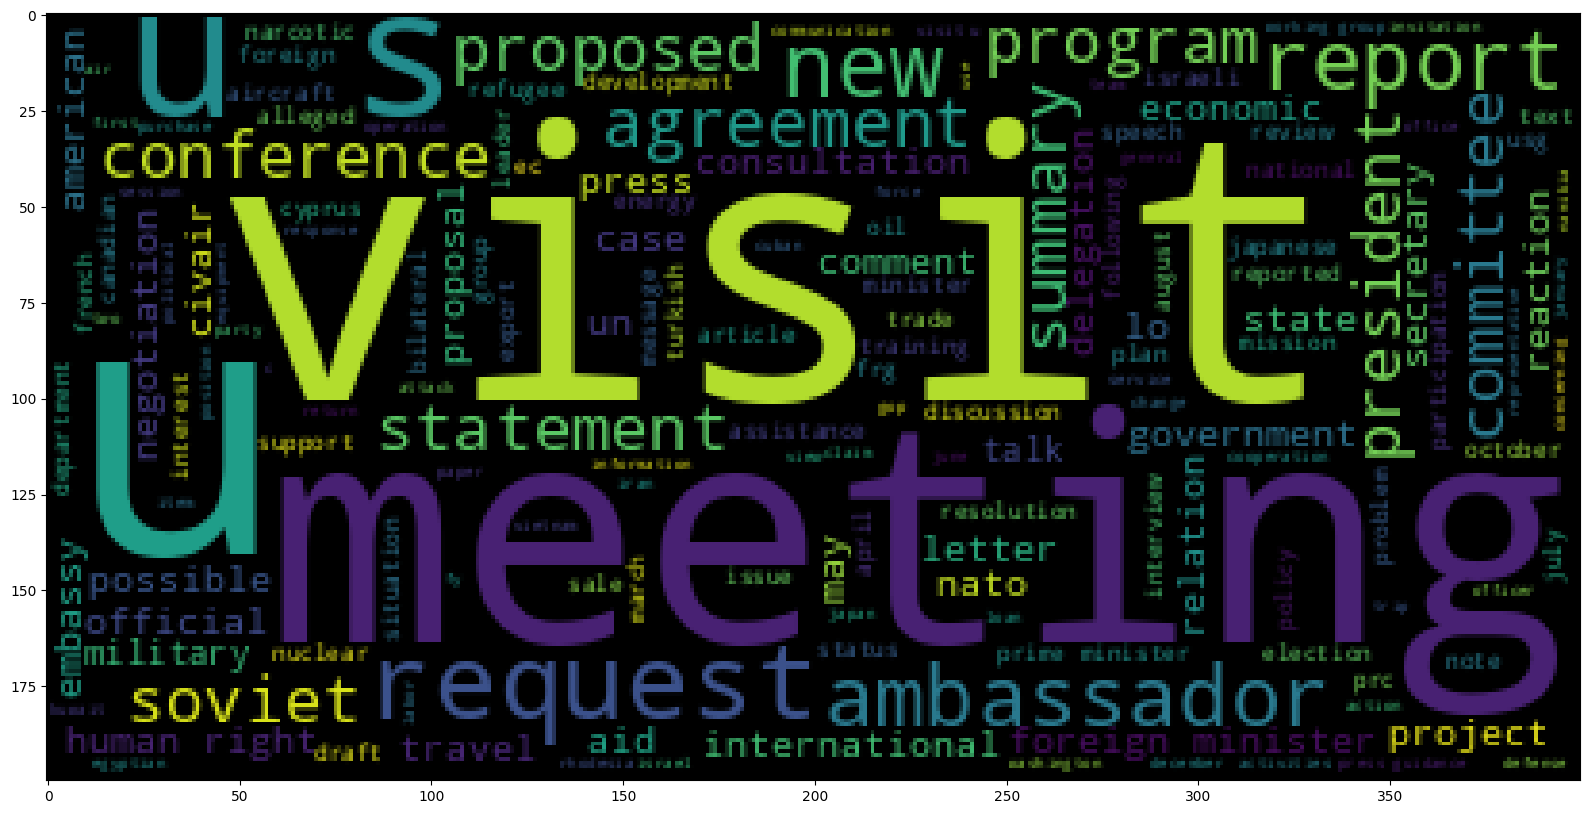

In [25]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

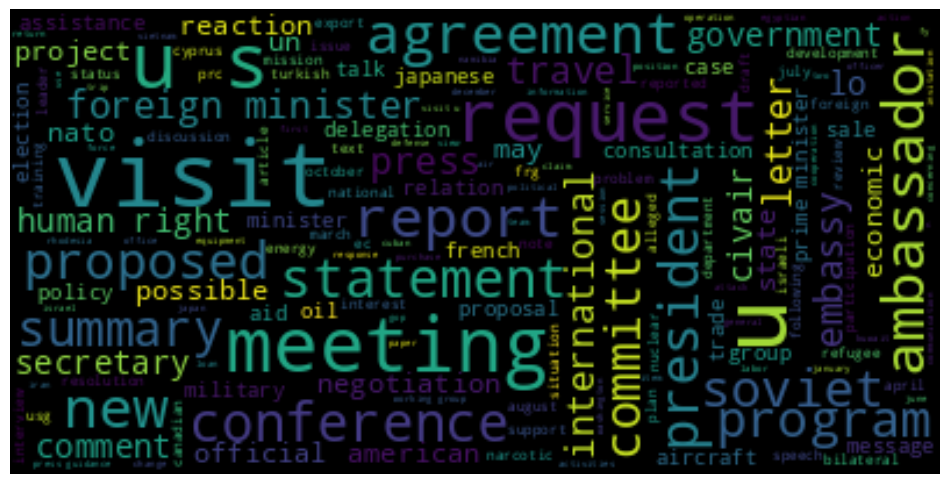

In [26]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()

### 2. Second task: Reading and converting text from PDF file

In [36]:
import textract

In [34]:
!ls ../../Data/pdf

AldousHuxley_bravenewworld.pdf		MarcelProust_EmBuscadoTempoPerdido.pdf
BNCC_EI_EF_110518_versaofinal_site.pdf	RobertFrost_Poetry.pdf


In [37]:
text = textract.process("../../Data/pdf/RobertFrost_Poetry.pdf").decode('utf-8')

In [38]:
text[0:100]

'Classic Poetry Series\n\nRobert Frost\n- poems -\n\nPublication Date:\n2004\n\nPublisher:\n\nPoemHunter.Com - '

In [39]:
print(text[0:100])

Classic Poetry Series

Robert Frost
- poems -

Publication Date:
2004

Publisher:

PoemHunter.Com - 


In [40]:
print(len(text))

115895


#### Cleaning and homogenizing text:

In [41]:
cleaned_text = text.lower()
cleaned_text = re.sub(' +',' ', cleaned_text)              #Remove multiple spaces
cleaned_text = re.sub(r'\n\s*\n', '\n', cleaned_text)      #Remove multiple newlines

In [42]:
print(len(cleaned_text))

115380


In [43]:
print(cleaned_text[0:200])

classic poetry series
robert frost
- poems -
publication date:
2004
publisher:
poemhunter.com - the world's poetry archive
"in white": frost's early version of design
a dented spider like a snow drop


In [44]:
list_words = cleaned_text.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation + '“”’“”–') for l in list_words]
list_words = [l for l in list_words if l not in stop_pt]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('the', 1338),
 ('and', 714),
 ('to', 636),
 ('i', 448),
 ('of', 403),
 ('in', 346),
 ('it', 329),
 ('that', 234),
 ('he', 215),
 ('was', 197),
 ('with', 196),
 ('but', 182),
 ('you', 180),
 ('', 176),
 ('on', 158),
 ('is', 138),
 ('they', 136),
 ("world's", 134),
 ('poetry', 133),
 ('not', 133)]

#### Finding ocurrences of a word:

In [47]:
word = 'love'
pos = 0 
positions = []

while pos != -1:
    position = cleaned_text.find(word,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print(f'The word "{word}" is found {len(positions)} times in the following positions:')
print(positions)

The word "love" is found 46 times in the following positions:
[4049, 5992, 6245, 6782, 6853, 8169, 8194, 13361, 13438, 14315, 26853, 27309, 27536, 27617, 27918, 41583, 41604, 42120, 45162, 45181, 46288, 49099, 50113, 50979, 52436, 53412, 54129, 54567, 66089, 67829, 70029, 70666, 72150, 83027, 92703, 101299, 108506, 109068, 109112, 110581, 112493, 113014, 114107, 114142, 114945, 115187]


#### Understanding contexts in which words occur:

In [48]:
# Pure Python
window = 18
for position in positions[0:20]:
    print(cleaned_text[position - window:position + window + len(word)].strip())

istic regimenting love
with which the mo
ith me,
and be my love in the rain.
the
rose.
come, be my love in the wet woods;
n after doubt
our love came back amain.
nd rout
and be my love in the rain.
robe
till.
for this is love and nothing else
d nothing else is love,
the which it is
he was crossed in love,
or so the story
talked about was love.
they soon saw he
d to lie and hear love things made dread
e right place for love:
www.poemhunter.c
27
bond and free
love has earth to whic
turn, i see
where love has left a printe
race.
and such is love and glad to be
bu
are.
yet some say love by being thrall
a
'twixt those that love.
two that don't l
e.
two that don't love can't live togeth
-- in the face of love.
you'd think his
where in song.
we love the things we lov
ove the things we love for what they are


In [49]:
# Using NLTK

tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_text)
tokens = [token for token in tokens if token not in stop_pt]
nltk_text = nltk.Text(tokens)

nltk_text.concordance(word.lower(), width=120, lines=20)

Displaying 20 of 37 matches:
 of the tenderer - than - thou collectivistic regimenting love with which the modern world is being swept . but this poo
om in vain . come over the hills and far with , and be my love in the rain . the birds have less to say themselves in th
hed like some wild , easily shattered rose . come , be my love in the wet woods ; come , where the boughs rain when it b
he fern ; and it seems like the time when after doubt our love came back amain . oh , come forth into the storm and rout
amain . oh , come forth into the storm and rout and be my love in the rain . robert frost www . poemhunter . - the world
 bill , and off blossom in mid air stands still . this is love and nothing else is love , the which it is reserved god a
n mid air stands still . this is love and nothing else is love , the which it is reserved god above to sanctify to what 
w in his teeth ; but it ' s more likely he was crossed in love , or so the story goes . it was some girl . anyway all he
 go

#### Words that occur in similar contexts than the query expression:

In [50]:
nltk_text.similar(word)

of death thought heard sound fire world in snow on saw ingredients
what darkness not said it flowers last leaves


#### [Collocations](http://en.wikipedia.org/wiki/Collocation) are expressions of multiple words which commonly co-occur.  
Ref: [NLTK](http://www.nltk.org/howto/collocations.html)  

In [51]:
nltk_text.collocation_list(num=20, window_size=20)

[('poemhunter', 'archive'),
 ('poemhunter', 'poetry'),
 ('poetry', 'archive'),
 ('www', 'archive'),
 ('www', 'poemhunter'),
 ('www', 'poetry'),
 ('robert', 'frost'),
 ('poemhunter', 'world'),
 ('world', 'archive'),
 ('world', 'poetry'),
 ('www', 'world'),
 ('robert', 'archive'),
 ('robert', 'poemhunter'),
 ('robert', 'poetry'),
 ('robert', 'www'),
 ('frost', 'archive'),
 ('frost', 'poemhunter'),
 ('frost', 'poetry'),
 ('frost', 'www'),
 ('robert', 'world')]

#### Finding bigrams using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [52]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

robert frost
poetry archive
too much
frost www
more than
s poetry
have been
so much
i am
they are
t know
they were
i should
you know
i didn
i don
to ask
to keep
the world
and then
out of
what was
when he
the sun
to say
i thought
to go
i could
i can
it was


### Finding bigrams using raw frequency

In [53]:
for a, b in (finder2.above_score(bigram_measures.raw_freq, 20.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

the world
poetry archive
s poetry
robert frost
frost www
in the
of the
to the
on the
it was
and the
i have
and i
and then
i was
at the
to be
it is
with the


### Finding Trigrams using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [54]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

snarled and rattled
robert frost www
s poetry archive
in the middle


### Finding trigrams using raw frequency

In [55]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq, 20.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

s poetry archive
robert frost www


### Finding n-grams using raw frequency

In [56]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(20)

[(('the', 'world', "'", 's'), 134),
 (('poemhunter', '.', '-', 'the'), 132),
 (('.', '-', 'the', 'world'), 132),
 (('-', 'the', 'world', "'"), 132),
 (('world', "'", 's', 'poetry'), 132),
 (("'", 's', 'poetry', 'archive'), 132),
 (('www', '.', 'poemhunter', '.'), 131),
 (('.', 'poemhunter', '.', '-'), 131),
 (('robert', 'frost', 'www', '.'), 117),
 (('frost', 'www', '.', 'poemhunter'), 117),
 (('.', 'robert', 'frost', 'www'), 101),
 (('i', 'don', "'", 't'), 18),
 (('i', 'didn', "'", 't'), 10),
 (('don', "'", 't', 'know'), 10),
 (('?', 'robert', 'frost', 'www'), 8),
 (('.', 'it', "'", 's'), 6),
 (('.', 'i', "'", 'm'), 6),
 (('it', "'", 's', 'not'), 5),
 (('don', "'", 't', 'want'), 5),
 (('i', 'won', "'", 't'), 5)]

#### Creating a dispersion plot of words in the document

<Figure size 1600x600 with 0 Axes>

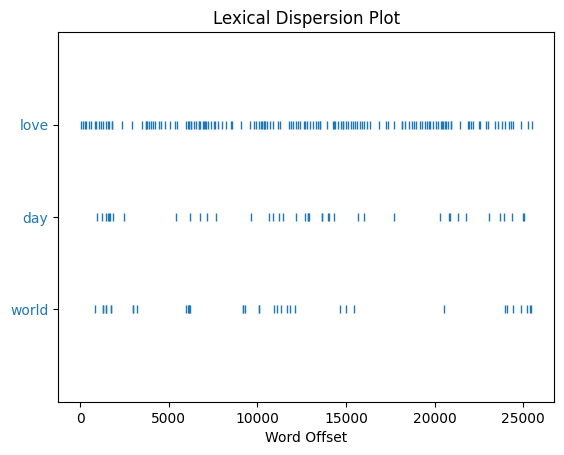

In [59]:
dispersion_words = ['world', 'day', 'love']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

#### Different ways to visualize frequent words:

In [60]:
freqdist.most_common(100)

[('the', 1338),
 ('and', 714),
 ('to', 636),
 ('i', 448),
 ('of', 403),
 ('in', 346),
 ('it', 329),
 ('that', 234),
 ('he', 215),
 ('was', 197),
 ('with', 196),
 ('but', 182),
 ('you', 180),
 ('', 176),
 ('on', 158),
 ('is', 138),
 ('they', 136),
 ("world's", 134),
 ('poetry', 133),
 ('not', 133),
 ('archive', 132),
 ('www.poemhunter.com', 131),
 ('his', 124),
 ('have', 123),
 ('frost', 121),
 ('robert', 118),
 ('my', 115),
 ('so', 110),
 ('from', 109),
 ('we', 108),
 ('one', 108),
 ('be', 103),
 ('all', 102),
 ('at', 101),
 ('what', 97),
 ('there', 92),
 ('him', 92),
 ('if', 91),
 ('had', 88),
 ('like', 83),
 ('by', 83),
 ('them', 81),
 ('when', 79),
 ('out', 79),
 ('or', 77),
 ('she', 76),
 ('her', 64),
 ('down', 58),
 ('up', 57),
 ('are', 55),
 ('make', 54),
 ('more', 54),
 ('where', 53),
 ('then', 52),
 ('see', 52),
 ('their', 52),
 ('know', 50),
 ('go', 49),
 ('could', 48),
 ('come', 48),
 ('some', 47),
 ('too', 46),
 ('us', 45),
 ('than', 45),
 ('back', 45),
 ('were', 45),
 ('say

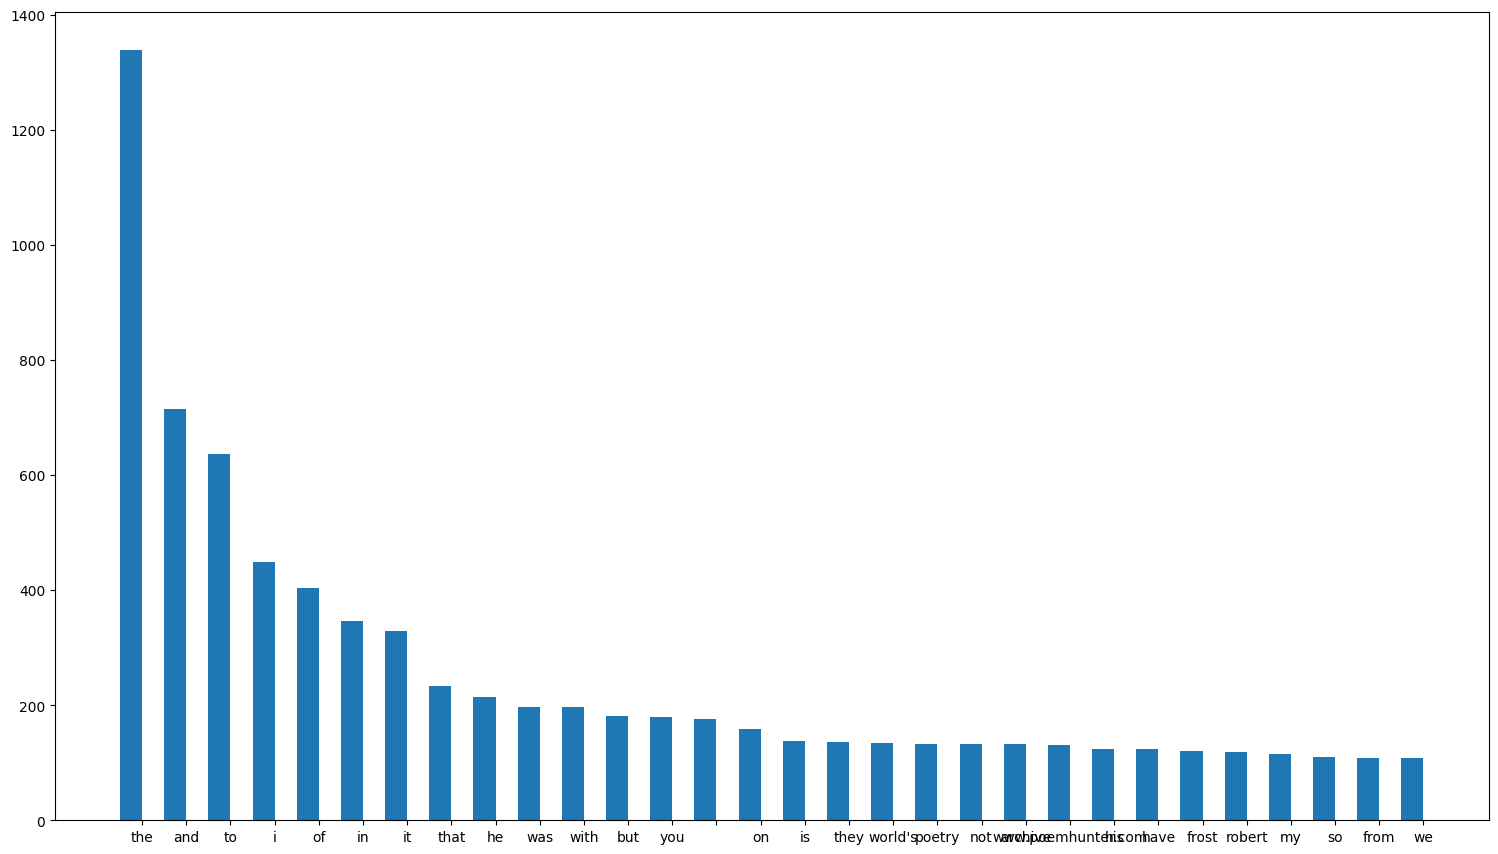

In [61]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

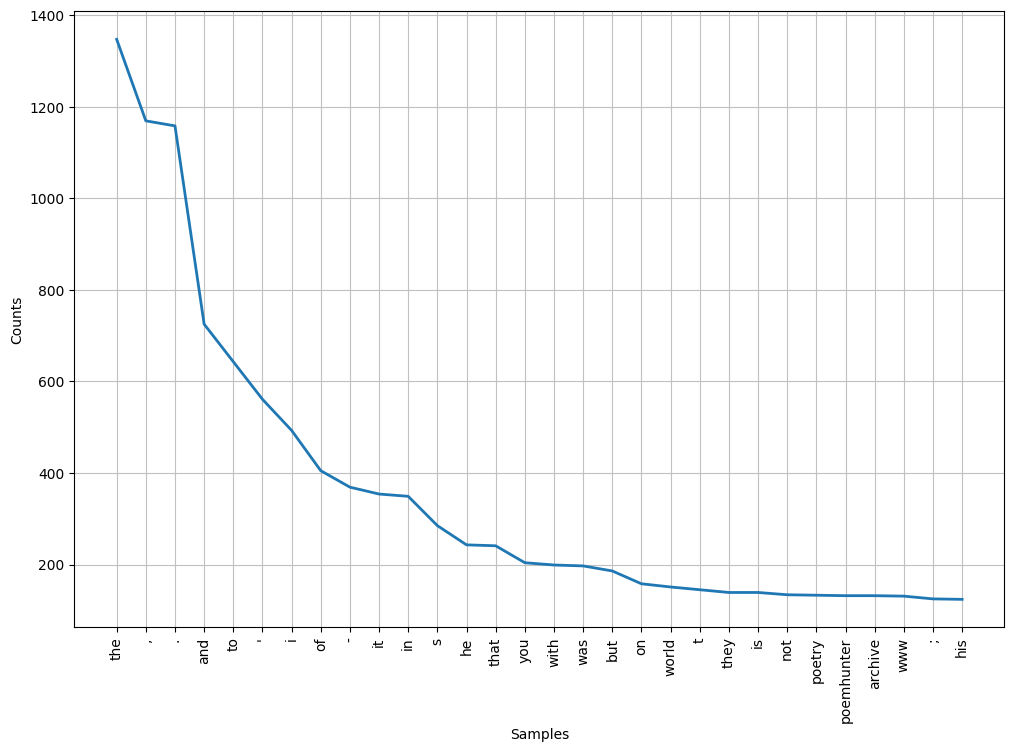

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [62]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

#### Cumulative distribution of frequencies:

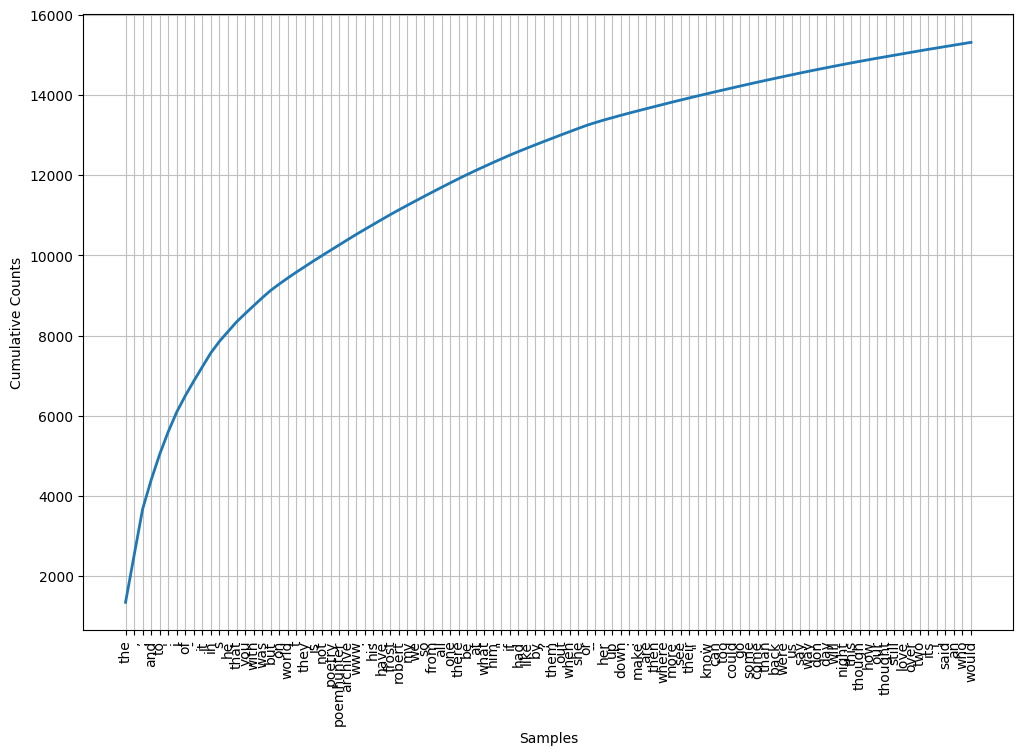

<AxesSubplot: xlabel='Samples', ylabel='Cumulative Counts'>

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(100, cumulative = True)

### 3. Third task: Extracting text from html pages using [Goose](https://github.com/goose3/goose3)

In [64]:
from goose3 import Goose

url = 'https://edition.cnn.com/2022/08/03/asia/china-reaction-pelosi-taiwan-intl-hnk-mic/index.html'

g = Goose()
#g = Goose(Goose({'use_meta_language': False, 'target_language':'en', 'parser_class':'lxml'}))

article = g.extract(url=url)

#### Extracting links

In [65]:
[l for l in article.links if l.startswith('http')]

['https://edition.cnn.com/specials/meanwhile-in-china',
 'https://edition.cnn.com/2022/08/02/politics/nancy-pelosi-visit-taipei-taiwan-trip/index.html',
 'https://www.cnn.com/asia/live-news/pelosi-taiwan-trip-us-china-08-03-22-intl-hnk/index.html',
 'https://www.cnn.com/2022/08/03/economy/china-suspends-imports-taiwan-products-intl-hnk/index.html']

#### Extracting title

In [66]:
article.title

'Pelosi angers China but Taiwan, not the US, may pay the higher price'

#### Extracting header

In [67]:
article.meta_description

'When US House Speaker Nancy Pelosi touched down in Taiwan on Tuesday night, China was ready with its response.'

#### Extracting cleaned text

In [68]:
article.cleaned_text[:]

'Editor’s Note: A version of this story appeared in CNN’s Meanwhile in China newsletter, a three-times-a-week update exploring what you need to know about the country’s rise and how it impacts the world. Sign up here.\n\nWhen US House Speaker Nancy Pelosi touched down in Taiwan on Tuesday night, China was ready with its response.\n\nIn quick succession, a slew of government and political bodies fired off statements condemning the visit and warning of its “severe impact” on US-China relations, while China’s military said it would immediately launch “air and sea exercises” and released a plan for drills surrounding the island in coming days.\n\nPelosi’s visit – the first by a top-ranked US lawmaker in 25 years and part of a larger Asia tour – was seen by Beijing as a “major political provocation” and a challenge to China’s sovereignty. China’s ruling Communist Party claims the self-governed democracy of Taiwan as its own, despite never having controlled it.\n\nDespite Beijing’s objection

## II - Translation, Part of Speech, advanced NLP functions

#### 3.1 Using [Textblob](http://textblob.readthedocs.io/en/dev/) ([Github](https://github.com/sloria/TextBlob))

[Another article](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)

In [70]:
from textblob import TextBlob
from textblob import Word

In [71]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/renato/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/renato/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/renato/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [72]:
text_en = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor. Chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant.
'''

text_de = '''
Familie Müller plant ihren Urlaub. Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. Als Reiseziel wählt sie Mallorca aus. 
Familie Müller bucht einen Flug auf die Mittelmeerinsel. Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. Familie Müller badet gerne im Meer.
Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. Dort warten schon viele Urlauber. Alle wollen nach Mallorca fliegen. 
Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 
Die Taschen sind Handgepäck. Familie Müller nimmt sie mit in das Flugzeug. 
Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. Es ist nicht mehr 
viel Zeit bis zum Abflug. Familie Müller geht durch die Sicherheitskontrolle. 
Als alle das richtige Gate erreichen, setzen sie sich in den Wartebereich. 
Kurz darauf wird ihre Flugnummer aufgerufen und Familie Müller steigt mit vielen 
anderen Passagieren in das Flugzeug nach Mallorca. Beim Starten fühlt sich Herr Müller 
nicht wohl. Ihm wird ein wenig übel. Nach zwei Stunden landet das Flugzeug. 
Am Gepäckband warten alle Passagiere noch auf ihr fehlendes Gepäck. Danach 
kann endlich der Urlaub beginnen.
'''

In [73]:
blob_en = TextBlob(text_en)
blob_de = TextBlob(text_de)

In [74]:
for s in blob_en.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor. 

Sentence: Chillingly
describes it--"assimilating flesh on contact. 

Sentence: Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists, etc., fearful of
artificial intelligence run rampant. 



In [75]:
for s in blob_de.sentences:
    print(f'Sentence: {s} \n')

Sentence: 
Familie Müller plant ihren Urlaub. 

Sentence: Sie geht in ein Reisebüro und lässt sich 
von einem Angestellten beraten. 

Sentence: Als Reiseziel wählt sie Mallorca aus. 

Sentence: Familie Müller bucht einen Flug auf die Mittelmeerinsel. 

Sentence: Sie bucht außerdem 
zwei Zimmer in einem großen Hotel direkt am Strand. 

Sentence: Familie Müller badet gerne im Meer. 

Sentence: Am Abflugtag fahren Herr und Frau Müller mit ihren beiden Kindern im Taxi zum 
Flughafen. 

Sentence: Dort warten schon viele Urlauber. 

Sentence: Alle wollen nach Mallorca fliegen. 

Sentence: Familie Müller hat viel Gepäck dabei: drei große Koffer und zwei Taschen. 

Sentence: Die Taschen sind Handgepäck. 

Sentence: Familie Müller nimmt sie mit in das Flugzeug. 

Sentence: Am Flugschalter checkt die Familie ein und erhält ihre Bordkarten. 

Sentence: Die Angestellte 
am Flugschalter erklärt Herrn Müller den Weg zum Flugsteig. 

Sentence: Es ist nicht mehr 
viel Zeit bis zum Abflug. 

Sentence: 

In [76]:
blob_en.sentences[1].words

WordList(['Chillingly', 'describes', 'it', 'assimilating', 'flesh', 'on', 'contact'])

Functions applied to the Word object:  

In [77]:
w = Word('Platform')
w.pluralize()

'Platforms'

In [78]:
blob_en.sentences[2].words.singularize()

WordList(['Snide', 'comparison', 'to', 'gelatin', 'be', 'damned', 'it', "'", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequence', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorist', 'etc', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

In [79]:
w = Word('engineering')
w.lemmatize("v") ## v here represents verb

'engineer'

In [80]:
w = Word('engineers')
w.lemmatize("n") ## n here represents name

'engineer'

POS tags  

In [81]:
blob_en.tags[0:10]

[('The', 'DT'),
 ('titular', 'JJ'),
 ('threat', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Blob', 'NNP'),
 ('has', 'VBZ'),
 ('always', 'RB'),
 ('struck', 'VBN'),
 ('me', 'PRP')]

In [82]:
blob_de.tags[0:10]

[('Familie', 'NNP'),
 ('Müller', 'NNP'),
 ('plant', 'NN'),
 ('ihren', 'NN'),
 ('Urlaub', 'NNP'),
 ('Sie', 'NNP'),
 ('geht', 'NN'),
 ('in', 'IN'),
 ('ein', 'JJ'),
 ('Reisebüro', 'NNP')]

Ngrams  

In [83]:
for ngram in blob_en.ngrams(2):
    print(ngram)

['The', 'titular']
['titular', 'threat']
['threat', 'of']
['of', 'The']
['The', 'Blob']
['Blob', 'has']
['has', 'always']
['always', 'struck']
['struck', 'me']
['me', 'as']
['as', 'the']
['the', 'ultimate']
['ultimate', 'movie']
['movie', 'monster']
['monster', 'an']
['an', 'insatiably']
['insatiably', 'hungry']
['hungry', 'amoeba-like']
['amoeba-like', 'mass']
['mass', 'able']
['able', 'to']
['to', 'penetrate']
['penetrate', 'virtually']
['virtually', 'any']
['any', 'safeguard']
['safeguard', 'capable']
['capable', 'of']
['of', 'as']
['as', 'a']
['a', 'doomed']
['doomed', 'doctor']
['doctor', 'Chillingly']
['Chillingly', 'describes']
['describes', 'it']
['it', 'assimilating']
['assimilating', 'flesh']
['flesh', 'on']
['on', 'contact']
['contact', 'Snide']
['Snide', 'comparisons']
['comparisons', 'to']
['to', 'gelatin']
['gelatin', 'be']
['be', 'damned']
['damned', 'it']
['it', "'s"]
["'s", 'a']
['a', 'concept']
['concept', 'with']
['with', 'the']
['the', 'most']
['most', 'devastating'

Noun Phrase Extraction

In [84]:
blob_en.noun_phrases

WordList(['titular threat', 'blob', 'ultimate movie monster', 'amoeba-like mass', 'chillingly', 'snide', 'potential consequences', 'grey goo scenario', 'technological theorists', 'artificial intelligence run rampant'])

In [85]:
blob_de.noun_phrases

WordList(['familie müller', 'plant ihren', 'urlaub', 'sie', 'reisebüro', 'und lässt sich von einem', 'angestellten', 'als reiseziel', 'wählt sie', 'mallorca', 'familie müller', 'bucht einen', 'flug', 'mittelmeerinsel', 'sie', 'bucht außerdem zwei', 'zimmer', 'einem großen hotel direkt', 'strand', 'familie müller', 'badet gerne im', 'meer', 'am abflugtag', 'herr', 'frau müller', 'mit ihren beiden', 'kindern', 'taxi', 'flughafen', 'dort', 'warten schon viele', 'urlauber', 'alle', 'wollen nach', 'mallorca', 'familie müller', 'hat viel', 'gepäck', 'drei große', 'koffer', 'und zwei', 'taschen', 'die taschen', 'handgepäck', 'familie müller', 'nimmt sie mit', 'flugzeug', 'am flugschalter', 'familie', 'ein und erhält ihre', 'bordkarten', 'die angestellte', 'flugschalter', 'herrn müller', 'weg', 'flugsteig', 'es', 'ist nicht mehr viel', 'zeit', 'bis zum', 'abflug', 'familie müller', 'geht durch', 'sicherheitskontrolle', 'als', 'alle das richtige gate erreichen', 'setzen sie sich', 'wartebereich

Sentiment Analysis  

In [86]:
for sentence in blob_en.sentences:
    print(sentence.sentiment.polarity)

0.2
-0.5
-0.34166666666666673


Spellcheck

In [87]:
sentence = TextBlob('The Austrien Centre for Digital Humanities and Cultural Heritaige from the Austrian Academy of Sciences')
sentence.correct()

TextBlob("The Austrian Centre for Digital Humanities and Cultural Heritage from the Austrian Academy of Sciences")

In [88]:
blob_en.words[5].spellcheck()

[('Low', 0.19878603945371776),
 ('Blow', 0.10925644916540213),
 ('Club', 0.10773899848254932),
 ('Clot', 0.1062215477996965),
 ('Slow', 0.09863429438543247),
 ('Flow', 0.07283763277693475),
 ('Lot', 0.05311077389984825),
 ('Mob', 0.03945371775417299),
 ('Glow', 0.03338391502276176),
 ('Log', 0.030349013657056147),
 ('Sob', 0.028831562974203338),
 ('Globe', 0.024279210925644917),
 ('Plot', 0.018209408194233688),
 ('Job', 0.01669195751138088),
 ('Plow', 0.013657056145675266),
 ('Rob', 0.007587253414264037),
 ('Slab', 0.006069802731411229),
 ('Los', 0.004552352048558422),
 ('Bob', 0.004552352048558422),
 ('Knob', 0.0030349013657056147),
 ('Flop', 0.0030349013657056147),
 ('Flog', 0.0030349013657056147),
 ('Blot', 0.0030349013657056147),
 ('Slot', 0.0015174506828528073),
 ('Slop', 0.0015174506828528073),
 ('Loi', 0.0015174506828528073),
 ('Lo', 0.0015174506828528073),
 ('Lb', 0.0015174506828528073),
 ('Lab', 0.0015174506828528073),
 ('Cob', 0.0015174506828528073),
 ('Bloc', 0.0015174506828

Text classification

In [89]:
training = [
('Tom Holland is a terrible spiderman.','neg'),
('a terrible Javert (Russell Crowe) ruined Les Miserables for me...','neg'),
('The Dark Knight Rises is the greatest superhero movie ever!','pos'),
('Fantastic Four should have never been made.','neg'),
('Wes Anderson is my favorite director!','pos'),
('Captain America 2 is pretty awesome.','pos'),
("Let's pretend \"Batman and Robin\" never happened..",'neg'),
]

testing = [
('Superman was never an interesting character.','neg'),
('Fantastic Mr Fox is an awesome film!','pos'),
('Dragonball Evolution is simply terrible!!','neg')
]

In [90]:
from textblob import classifiers
nb_classifier = classifiers.NaiveBayesClassifier(training)
dt_classifier = classifiers.DecisionTreeClassifier(training)

In [91]:
print (nb_classifier.accuracy(testing))

1.0


In [92]:
print (dt_classifier.accuracy(testing))

0.6666666666666666


In [93]:
nb_classifier.show_informative_features(4)

Most Informative Features
            contains(is) = True              pos : neg    =      2.9 : 1.0
             contains(a) = False             pos : neg    =      1.8 : 1.0
         contains(never) = False             pos : neg    =      1.8 : 1.0
      contains(terrible) = False             pos : neg    =      1.8 : 1.0


In [94]:
blob = TextBlob('the weather is terrible!', classifier=dt_classifier)
print (blob.classify())

pos


#### 3.2 Using [Spacy](https://spacy.io/)

[Doc 1](https://spacy.io/usage/spacy-101#lightning-tour), [Doc 2](https://github.com/explosion/spacy-notebooks), [Doc 3](https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb)

Downloading the language models from Spacy

In [98]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!python -m spacy download pt_core_news_sm
!python -m spacy download de_core_news_md

!python -m spacy validate

2022-12-16 08:53:15.387932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 08:53:15.499464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-16 08:53:15.499481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 08:53:15.521486: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 08:53:15.966368: W tensorflow/stream_executor/platform/de

Load resources and process text

In [99]:
import spacy

In [100]:
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
#pt_nlp = spacy.load('pt_core_news_sm')

In [101]:
text_german = '''
Der du von dem Himmel bist,
Alles Leid und Schmerzen stillest,
Den, der doppelt elend ist,
Doppelt mit Erquickung füllest;
Ach, ich bin des Treibens müde!
Was soll all der Schmerz und Lust?
Süßer Friede,
Komm, ach komm in meine Brust!
'''

text_english = '''
somewhere i have never travelled, gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near.
Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully, mysteriously) her first rose.
Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility: whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing.
I do not know what it is about you that closes
and opens; only something in me understands
the voice of your eyes is deeper than all roses)
nobody, not even the rain, has such small hands.

'''

text_portuguese = '''
Ora (direis) ouvir estrelas! Certo
Perdeste o senso!" E eu vos direi, no entanto,
Que, para ouvi-las, muita vez desperto
E abro as janelas, pálido de espanto...

E conversamos toda a noite, enquanto
A via-láctea, como um pálio aberto,
Cintila. E, ao vir do sol, saudoso e em pranto,
Inda as procuro pelo céu deserto.

Direis agora: "Tresloucado amigo!
Que conversas com elas? Que sentido
Tem o que dizem, quando estão contigo?"

E eu vos direi: "Amai para entendê-las!
Pois só quem ama pode ter ouvido
Capaz de ouvir e de entender estrelas. 
'''

In [102]:
en_doc = en_nlp(text_english)
de_doc = de_nlp(text_german)
#pt_doc = pt_nlp(text_portuguese)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document:

In [103]:
print(en_doc[0:7])


somewhere i have never travelled,


You can also iterate over the sentences. doc.sents is a generator object, so we can use next():

In [104]:
en_Sents = list(en_doc.sents)
print(en_Sents)

[
somewhere i have never travelled, gladly beyond
any experience,your eyes have their silence:
in your most frail gesture are things which enclose me,
or which i cannot touch because they are too near.
, Your slightest look easily will unclose me
though i have closed myself as fingers,
you open always petal by petal myself as Spring opens
(touching skilfully, mysteriously) her first rose.
, Or if your wish be to close me,i and
my life will shut very beautifully,suddenly,
as when the heart of this flower imagines
the snow carefully everywhere descending;
nothing which we are to perceive in this world equals
the power of your intense fragility: whose texture
compels me with the colour of its countries,
rendering death and forever with each breathing.
, I do not know what it is about you that closes
and opens; only something in me understands
the voice of your eyes is deeper than all roses)
nobody, not even the rain, has such small hands.

]


For example, let's find the longest sentence(s):

In [105]:
SentenceLengths = [len(sent) for sent in en_Sents]
[sent for sent in en_Sents if len(sent) == max(SentenceLengths)]

[Or if your wish be to close me,i and
 my life will shut very beautifully,suddenly,
 as when the heart of this flower imagines
 the snow carefully everywhere descending;
 nothing which we are to perceive in this world equals
 the power of your intense fragility: whose texture
 compels me with the colour of its countries,
 rendering death and forever with each breathing.]

Exploring Words: each word has a huge number of properties:

In [106]:
print(en_doc[2])
print(type(en_doc[2]))

i
<class 'spacy.tokens.token.Token'>


In [107]:
[prop for prop in dir(en_doc[2]) if not prop.startswith('_')]

['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_dep',
 'has_extension',
 'has_head',
 'has_morph',
 'has_vector',
 'head',
 'i',
 'idx',
 'iob_strings',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_end',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'set_morph',
 'shape',
 'sh

Using just the indices (.i), we can make a lexical dispersion plot for the occurrences of that word in the novel. (This is just the SpaCy equivalent of the lexical dispersion plot from the NLTK)

In [108]:
en_doc[2].i

2

In [109]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram([word.i for word in haystack if word.text.lower() == needle], bins=50)[0])

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

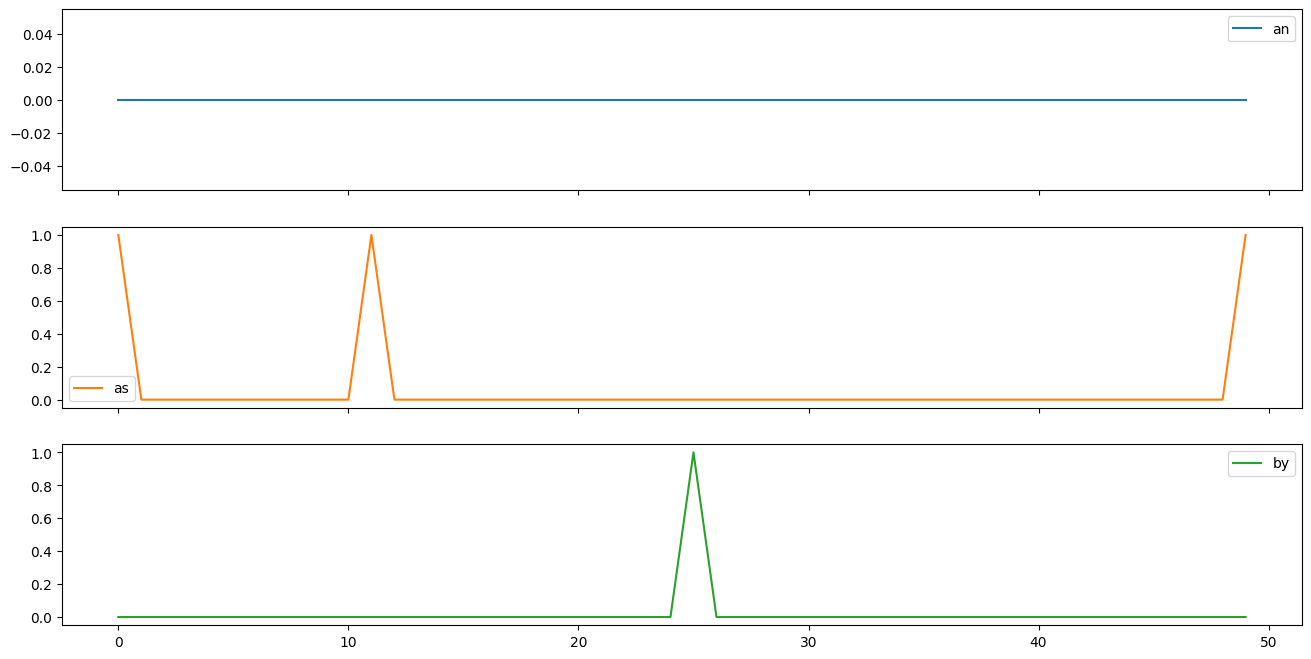

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), en_doc) 
     for name in ['an', 'as', 'by']}
).plot(subplots=True)

Exploring [Named Entities](https://spacy.io/api/annotation)

Named entities can be accessed through doc.ents

In [111]:
news_text = '''
Mexico City (CNN)At least 54 people were killed and more than 100 injured when a truck overturned in southern Mexico on Thursday, with most of the victims believed to be migrants from Central America, according to local authorities.
The incident happened in Mexico's Chiapas state, which borders Guatemala, when the truck carrying dozens of migrants crashed. Photos from the scene show the truck on its side next to a footbridge and bodies laid out on the road wrapped in body bags.
State Governor Rutilio Escandón tweeted that in addition to the deaths, 105 people were injured in the crash -- among them are 83 men and 22 and women.
'''

en_doc2 = en_nlp(news_text)

In [112]:
set([(w ,w.label_) for w in en_doc2.ents])

{(Mexico City, 'GPE'),
 (CNN)At least 54, 'CARDINAL'),
 (more than 100, 'CARDINAL'),
 (Mexico, 'GPE'),
 (Thursday, 'DATE'),
 (Central America, 'LOC'),
 (Mexico, 'GPE'),
 (Chiapas, 'GPE'),
 (Guatemala, 'GPE'),
 (dozens, 'CARDINAL'),
 (State, 'ORG'),
 (Rutilio Escandón, 'PERSON'),
 (105, 'CARDINAL'),
 (83, 'CARDINAL'),
 (22, 'CARDINAL')}

In [113]:
[ent for ent in en_doc2.ents if ent.label_ == 'LOC']

[Central America]

In [114]:
[ent for ent in en_doc2.ents if ent.label_ == 'GPE']

[Mexico City, Mexico, Mexico, Chiapas, Guatemala]

Parts of Speech  

Each word already has a part of speech and a tag associated with it.

In [115]:
tagDict = {w.pos: w.pos_ for w in en_doc2} 
tagDict

{103: 'SPACE',
 96: 'PROPN',
 97: 'PUNCT',
 86: 'ADV',
 93: 'NUM',
 92: 'NOUN',
 87: 'AUX',
 100: 'VERB',
 89: 'CCONJ',
 84: 'ADJ',
 85: 'ADP',
 98: 'SCONJ',
 90: 'DET',
 94: 'PART',
 95: 'PRON'}

<AxesSubplot: >

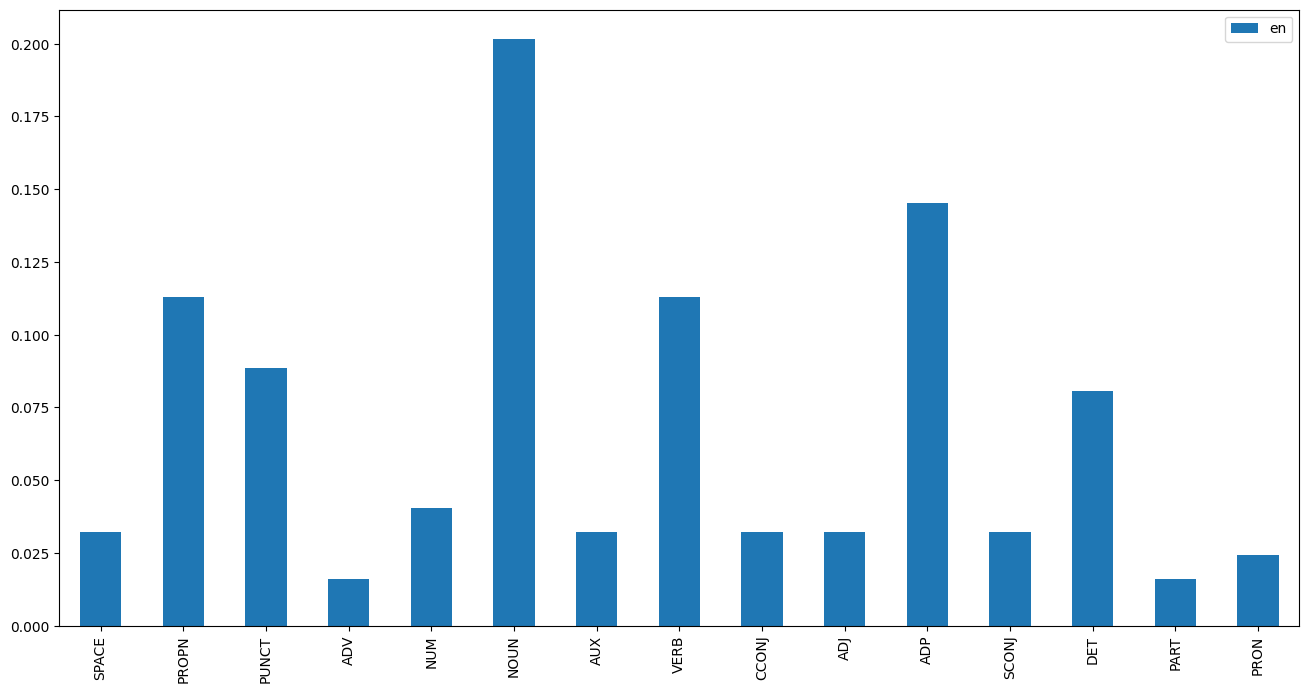

In [116]:
en_docPOS = pd.Series(en_doc2.count_by(spacy.attrs.POS))/len(en_doc2)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [117]:
en_docProns = [w for w in en_doc2 if w.pos_ == 'PRON']
Counter([w.text.strip() for w in en_docProns]).most_common(10)

[('which', 1), ('its', 1), ('them', 1)]

In [118]:
en_docSents = [sent for sent in en_doc2.sents if 'Mexico' in sent.text]
en_docSents

[
 Mexico City (CNN)At least 54 people were killed and more than 100 injured when a truck overturned in southern Mexico on Thursday, with most of the victims believed to be migrants from Central America, according to local authorities.,
 The incident happened in Mexico's Chiapas state, which borders Guatemala, when the truck carrying dozens of migrants crashed.]

In [119]:
for word in en_docSents[1]: 
    print(word, word.tag_, word.pos_)

The DT DET
incident NN NOUN
happened VBD VERB
in IN ADP
Mexico NNP PROPN
's POS PART
Chiapas NNP PROPN
state NN NOUN
, , PUNCT
which WDT PRON
borders VBZ VERB
Guatemala NNP PROPN
, , PUNCT
when WRB SCONJ
the DT DET
truck NN NOUN
carrying VBG VERB
dozens NNS NOUN
of IN ADP
migrants NNS NOUN
crashed VBD VERB
. . PUNCT


Dependency Parsing  

Now let's analyze the structure of the sentence.  

This sentence has lots of properties:  

In [120]:
[prop for prop in dir(en_docSents[1]) if not prop.startswith('_')]

['as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'id',
 'id_',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root:

In [121]:
en_docSents[1].root

happened

In [122]:
list(en_docSents[1].root.children)

[incident, in, .]

In [123]:
for word in en_docSents[1]: 
    print(word, ': ', str(list(word.children)))

The :  []
incident :  [The]
happened :  [incident, in, .]
in :  [state]
Mexico :  ['s]
's :  []
Chiapas :  []
state :  [Mexico, Chiapas, ,, borders]
, :  []
which :  []
borders :  [which, Guatemala]
Guatemala :  [,, crashed]
, :  []
when :  []
the :  []
truck :  [the, carrying]
carrying :  [dozens]
dozens :  [of]
of :  [migrants]
migrants :  []
crashed :  [when, truck]
. :  []


Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document.  
Let's see what the distribution is like:

<AxesSubplot: >

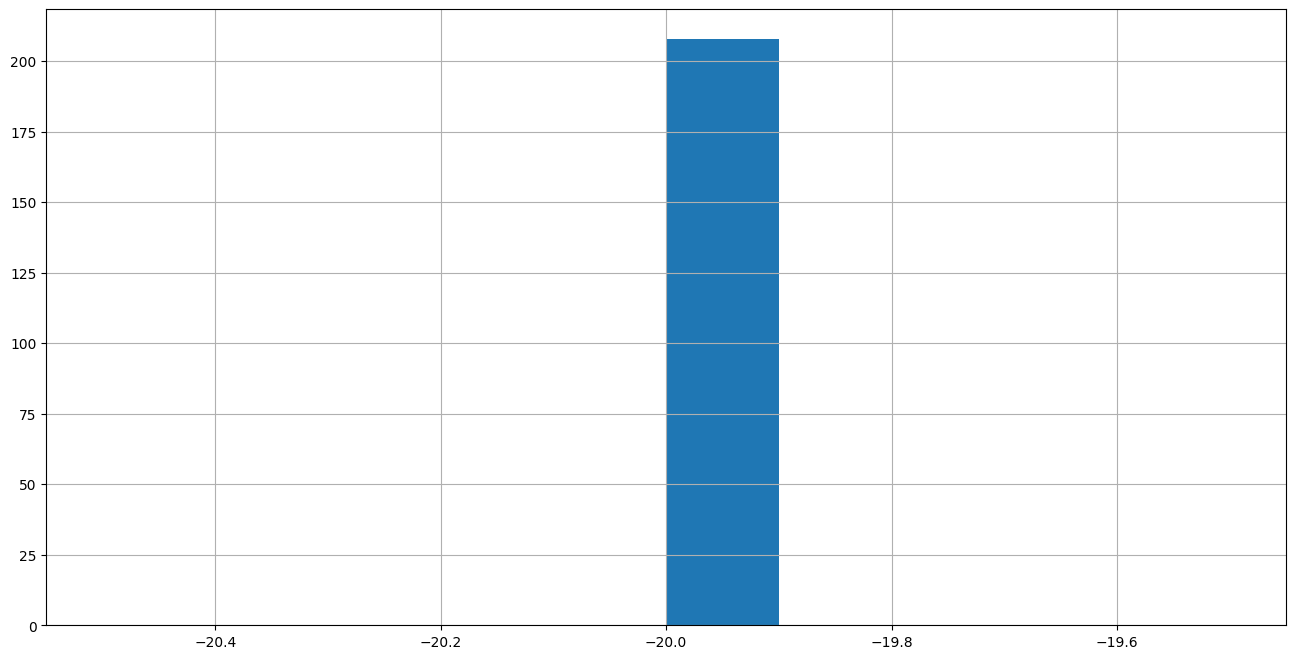

In [124]:
probabilities = [word.prob for word in en_doc] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words

In [125]:
list(set([word.text.strip().lower() for word in en_doc if word.prob < -19]))[:20]

['',
 'can',
 'i',
 'gesture',
 'me',
 'everywhere',
 'its',
 'descending',
 'very',
 'than',
 'when',
 'too',
 'deeper',
 'intense',
 'nobody',
 'of',
 'whose',
 '(',
 'rain',
 'only']

In [126]:
Counter([word.text.strip().lower() 
         for word in en_doc 
         if word.prob < -19.5]).most_common(20)

[('', 21),
 (',', 11),
 ('your', 6),
 ('the', 6),
 ('i', 5),
 ('me', 5),
 ('.', 4),
 ('of', 4),
 ('have', 3),
 ('in', 3),
 ('are', 3),
 ('which', 3),
 ('not', 3),
 ('as', 3),
 ('and', 3),
 ('eyes', 2),
 (':', 2),
 ('or', 2),
 ('will', 2),
 ('myself', 2)]

In [127]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.text.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [128]:
docGrams = set(ngrams(en_doc, 3))

In [129]:
for gram in docGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(snow, carefully, everywhere)
(the, voice, of)
(colour, of, its)
(closed, myself, as)
(me, though, i)
(i, have, never)
(it, is, about)
(about, you, that)
(all, roses, nobody)
(petal, myself, as)
(your, intense, fragility)
(fingers, you, open)
(perceive, in, this)
(myself, as, Spring)
(first, rose, Or)
(gladly, beyond, any)
(is, deeper, than)
(heart, of, this)
(the, colour, of)
(and, forever, with)
(we, are, to)
(Your, slightest, look)
(voice, of, your)
(everywhere, descending, nothing)
(shut, very, beautifully)
(your, most, frail)
(and, my, life)
(beyond, any, experience)
(to, close, me)
(can, not, touch)
(will, shut, very)
(i, and, my)
(petal, by, petal)
(each, breathing, do)
(understands, the, voice)
(of, your, eyes)
(near, Your, slightest)
(are, too, near)
(close, me, i)
(very, beautifully, suddenly)
(not, even, the)
(the, snow, carefully)
(as, when, the)
(nothing, which, we)
(your, eyes, have)
(mysteriously, her, first)
(in, me, understands)
(roses, nobody, not)
(enclose, me, or)
(

### EDA text pipeline based in [this](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) and [this](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) articles  

#### Analyzing text statistics

Text statistics visualizations are simple but very insightful techniques. 

They include:

- word frequency analysis,
- sentence length analysis,
- average word length analysis

In [135]:
!ls ../../Data/zip/

abcnews-date-text.zip  exp_sub.zip  twitter_stream.zip
den-2008.zip	       flights.zip  vehicles.zip


In [137]:
import zipfile

zf = zipfile.ZipFile('../../Data/zip/abcnews-date-text.zip') 
news= pd.read_csv(zf.open('abcnews-date-text.csv'),nrows=10000) 
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


#### First, let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

<AxesSubplot: >

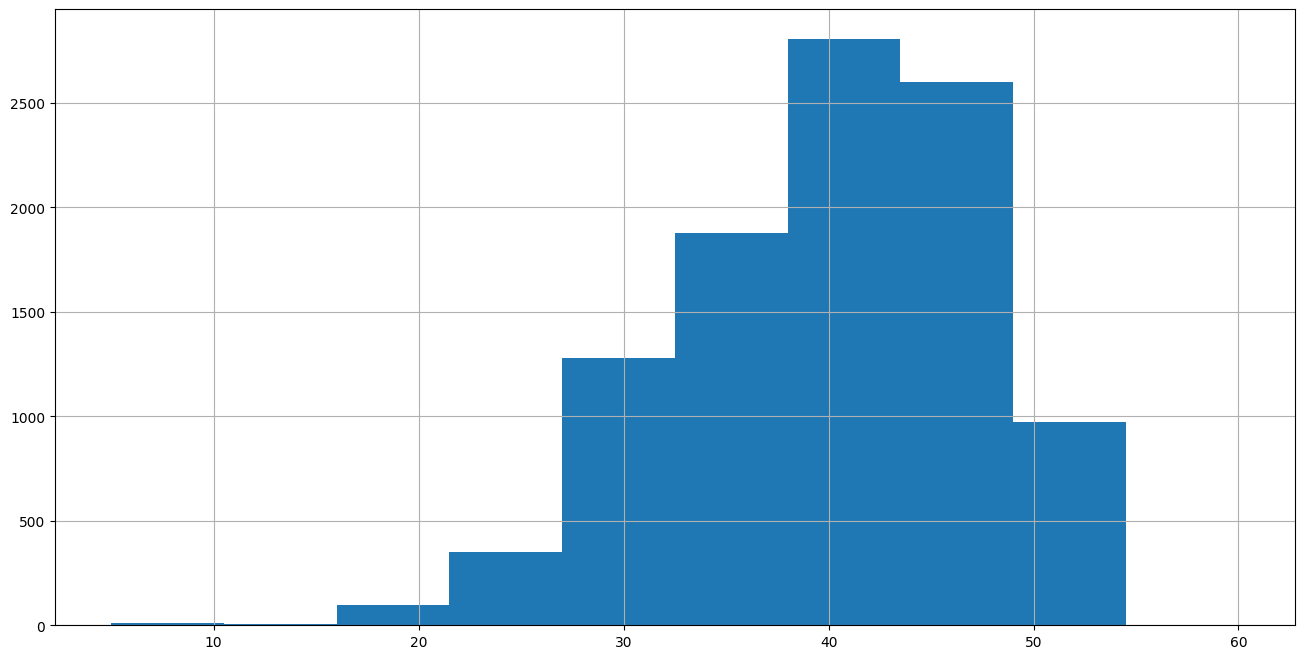

In [138]:
news['headline_text'].str.len().hist()

#### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

<AxesSubplot: >

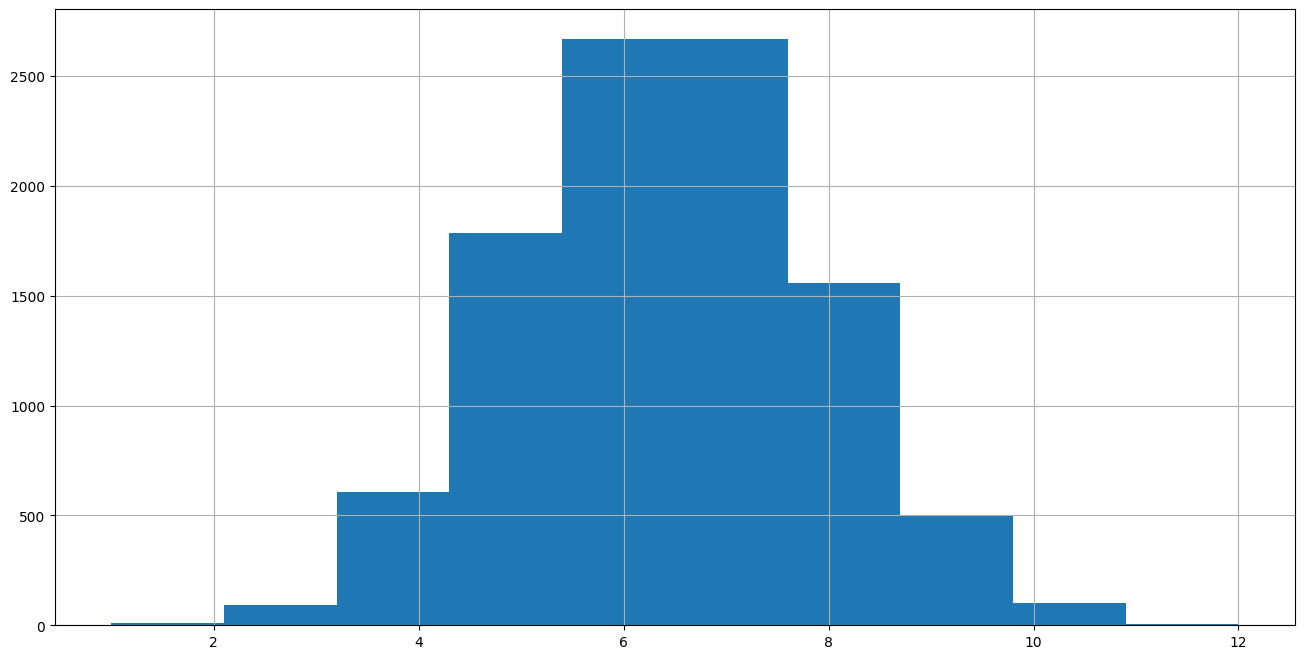

In [139]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

#### Up next, let’s check the average word length in each sentence.

<AxesSubplot: >

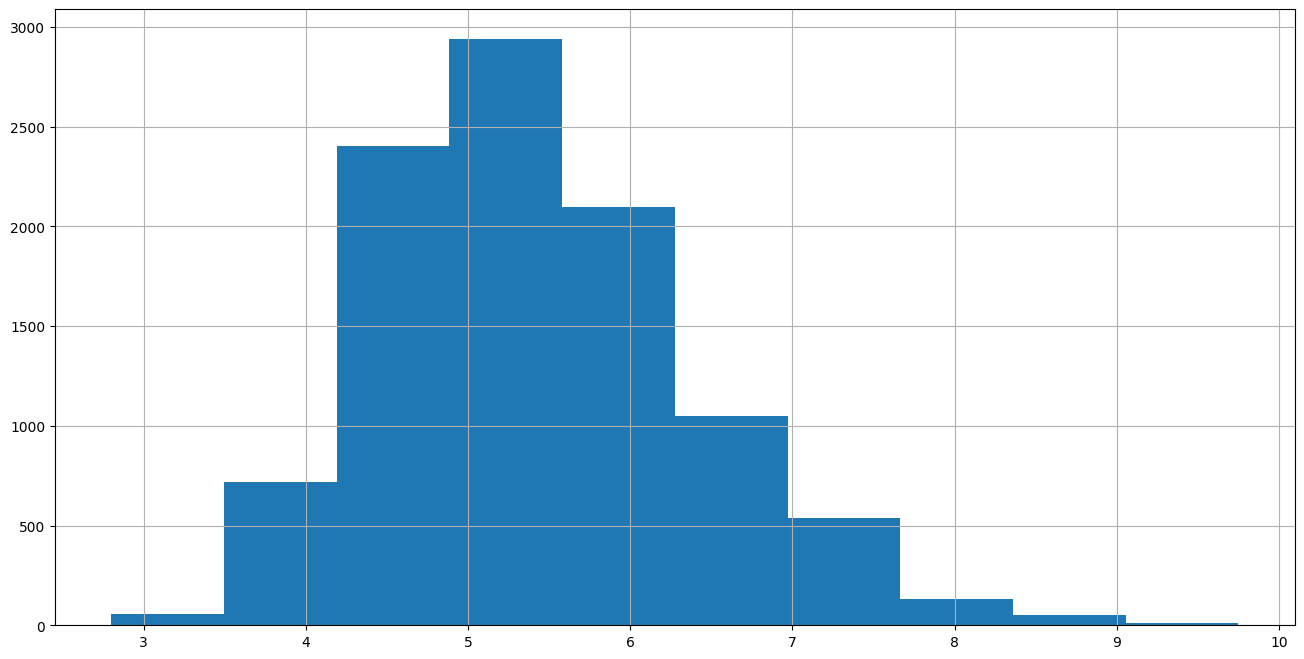

In [140]:
news['headline_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Loading stopwords list

In [141]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

#### Now, we’ll  create the corpus.

In [142]:
corpus=[]
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

#### Plot top stopwords

<BarContainer object of 10 artists>

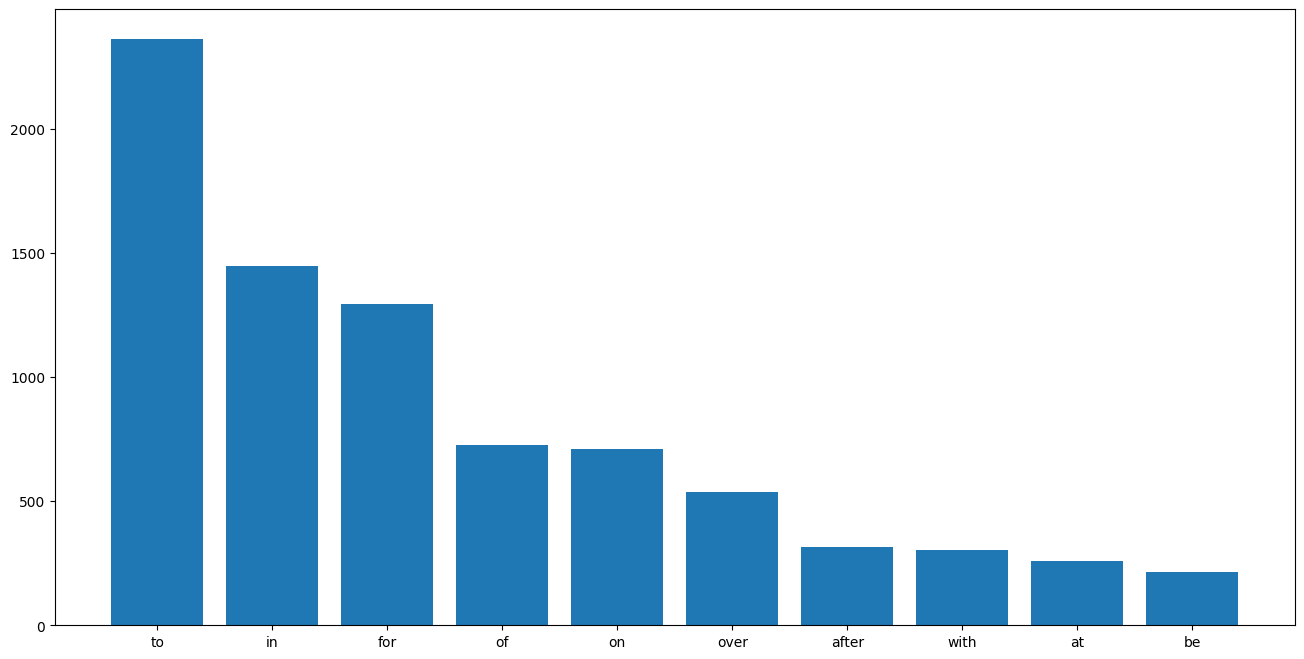

In [143]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

#### We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples.

<AxesSubplot: >

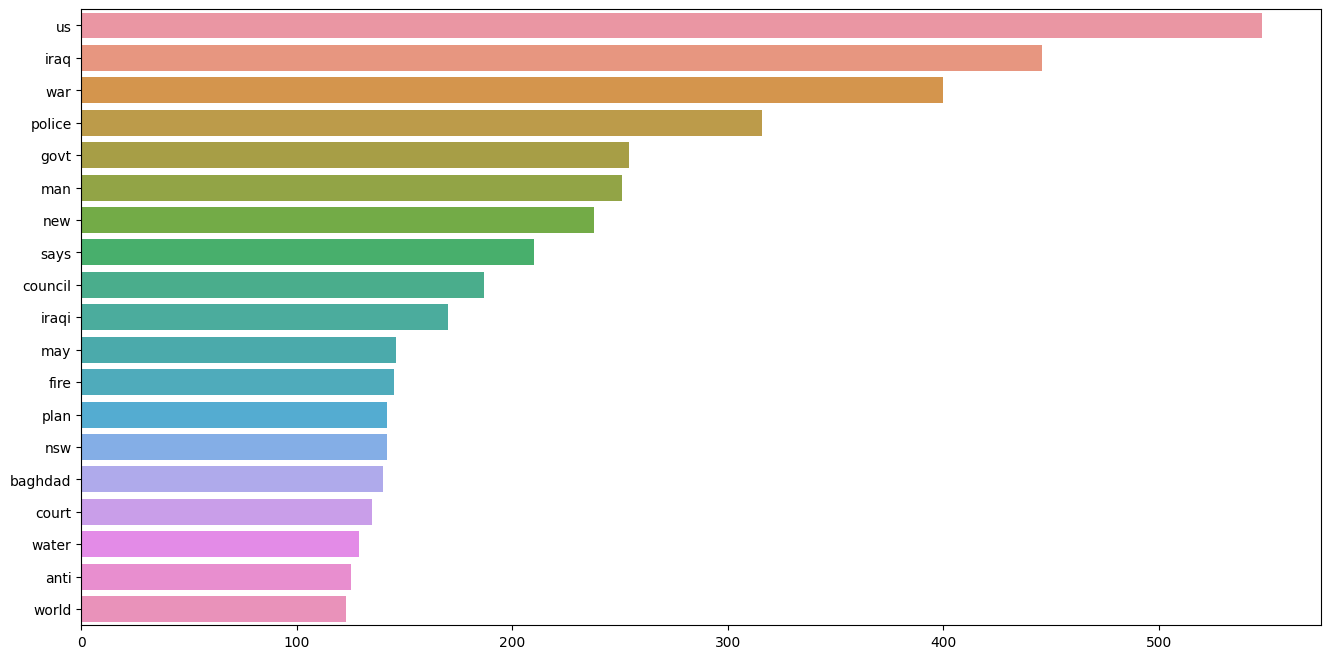

In [144]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### Ngram exploration  

Ngrams are simply contiguous sequences of n words.   

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  

In [145]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

#### To build a representation of our vocabulary we will use Countvectorizer.

In [146]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot: >

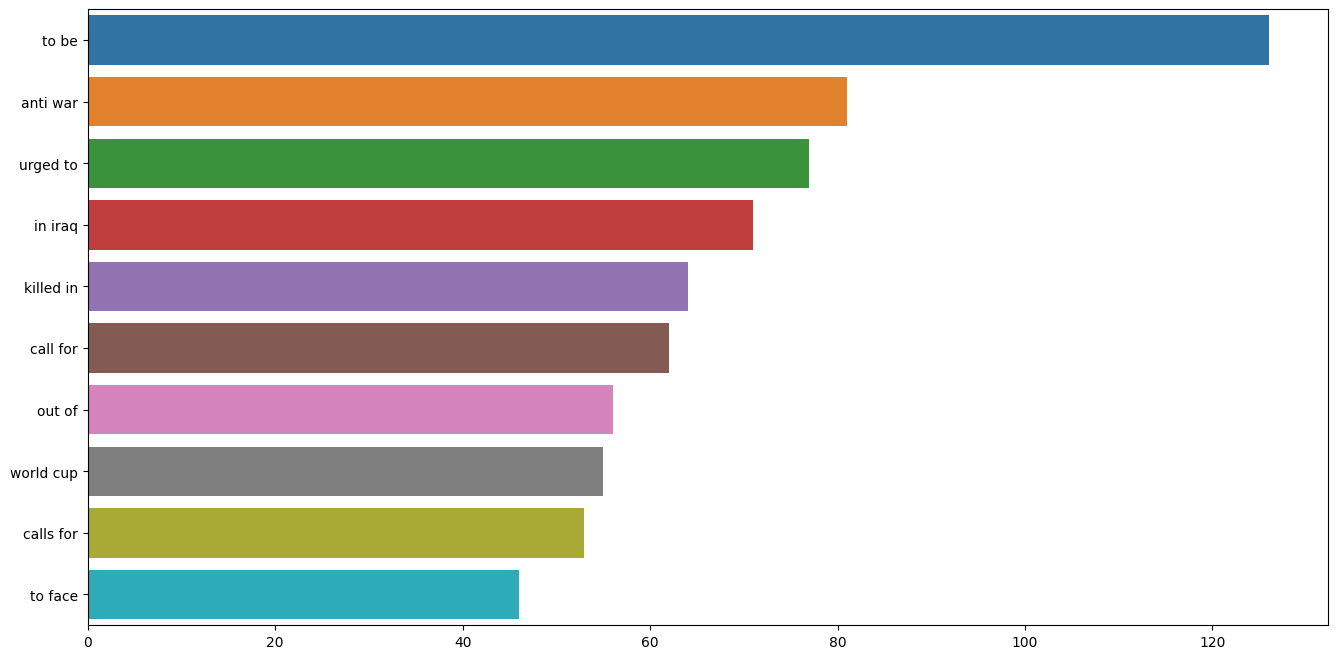

In [147]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### How about trigrams?

<AxesSubplot: >

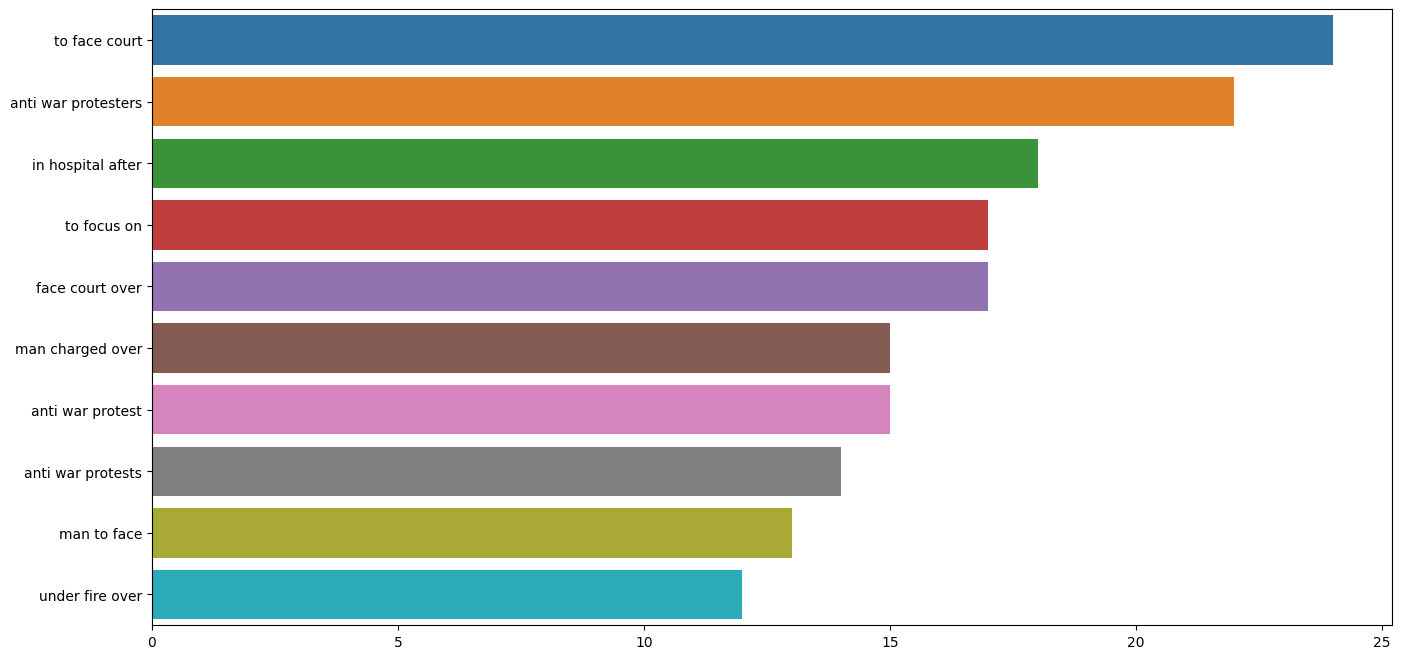

In [148]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

#### Topic Modeling exploration with pyLDAvis

In [149]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_news(news)

[nltk_data] Downloading package punkt to /home/renato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/renato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Now, let’s create the bag of words model using gensim

In [151]:
import gensim

In [152]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Create the LDA model:

In [153]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

[(0,
  '0.011*"iraq" + 0.006*"man" + 0.006*"crash" + 0.006*"get" + 0.006*"govt" + 0.006*"police" + 0.005*"baghdad" + 0.005*"car" + 0.005*"new" + 0.005*"killed"'),
 (1,
  '0.013*"plan" + 0.010*"man" + 0.009*"war" + 0.008*"iraqi" + 0.007*"new" + 0.006*"govt" + 0.005*"back" + 0.005*"face" + 0.005*"protest" + 0.005*"claim"'),
 (2,
  '0.011*"police" + 0.010*"war" + 0.010*"baghdad" + 0.009*"troop" + 0.007*"iraq" + 0.007*"sars" + 0.006*"iraqi" + 0.005*"death" + 0.004*"anti" + 0.004*"korea"'),
 (3,
  '0.011*"iraq" + 0.011*"war" + 0.009*"say" + 0.006*"australia" + 0.005*"open" + 0.005*"lead" + 0.005*"minister" + 0.005*"coast" + 0.004*"welcome" + 0.004*"hit"')]

#### What is the Dominant topic and its percentage contribution in each document

In [154]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus, news['headline_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/tmp/ipykernel_19351/1478419625.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8730,"plan, man, war, iraqi, new, govt, back, face, ...",aba decides against community broadcasting lic...
1,1,0,0.6720,"iraq, man, crash, get, govt, police, baghdad, ...",act fire witnesses must be aware of defamation
2,2,0,0.8441,"iraq, man, crash, get, govt, police, baghdad, ...",a g calls for infrastructure protection summit
3,3,2,0.8879,"police, war, baghdad, troop, iraq, sars, iraqi...",air nz staff in aust strike for pay rise
4,4,2,0.6586,"police, war, baghdad, troop, iraq, sars, iraqi...",air nz strike to affect australian travellers
5,5,3,0.4636,"iraq, war, say, australia, open, lead, ministe...",ambitious olsson wins triple jump
6,6,2,0.6684,"police, war, baghdad, troop, iraq, sars, iraqi...",antic delighted with record breaking barca
7,7,3,0.9041,"iraq, war, say, australia, open, lead, ministe...",aussie qualifier stosur wastes four memphis match
8,8,2,0.4646,"police, war, baghdad, troop, iraq, sars, iraqi...",aust addresses un security council over iraq
9,9,3,0.5345,"iraq, war, say, australia, open, lead, ministe...",australia is locked into war timetable opp


#### Frequency Distribution of Word Counts in Documents

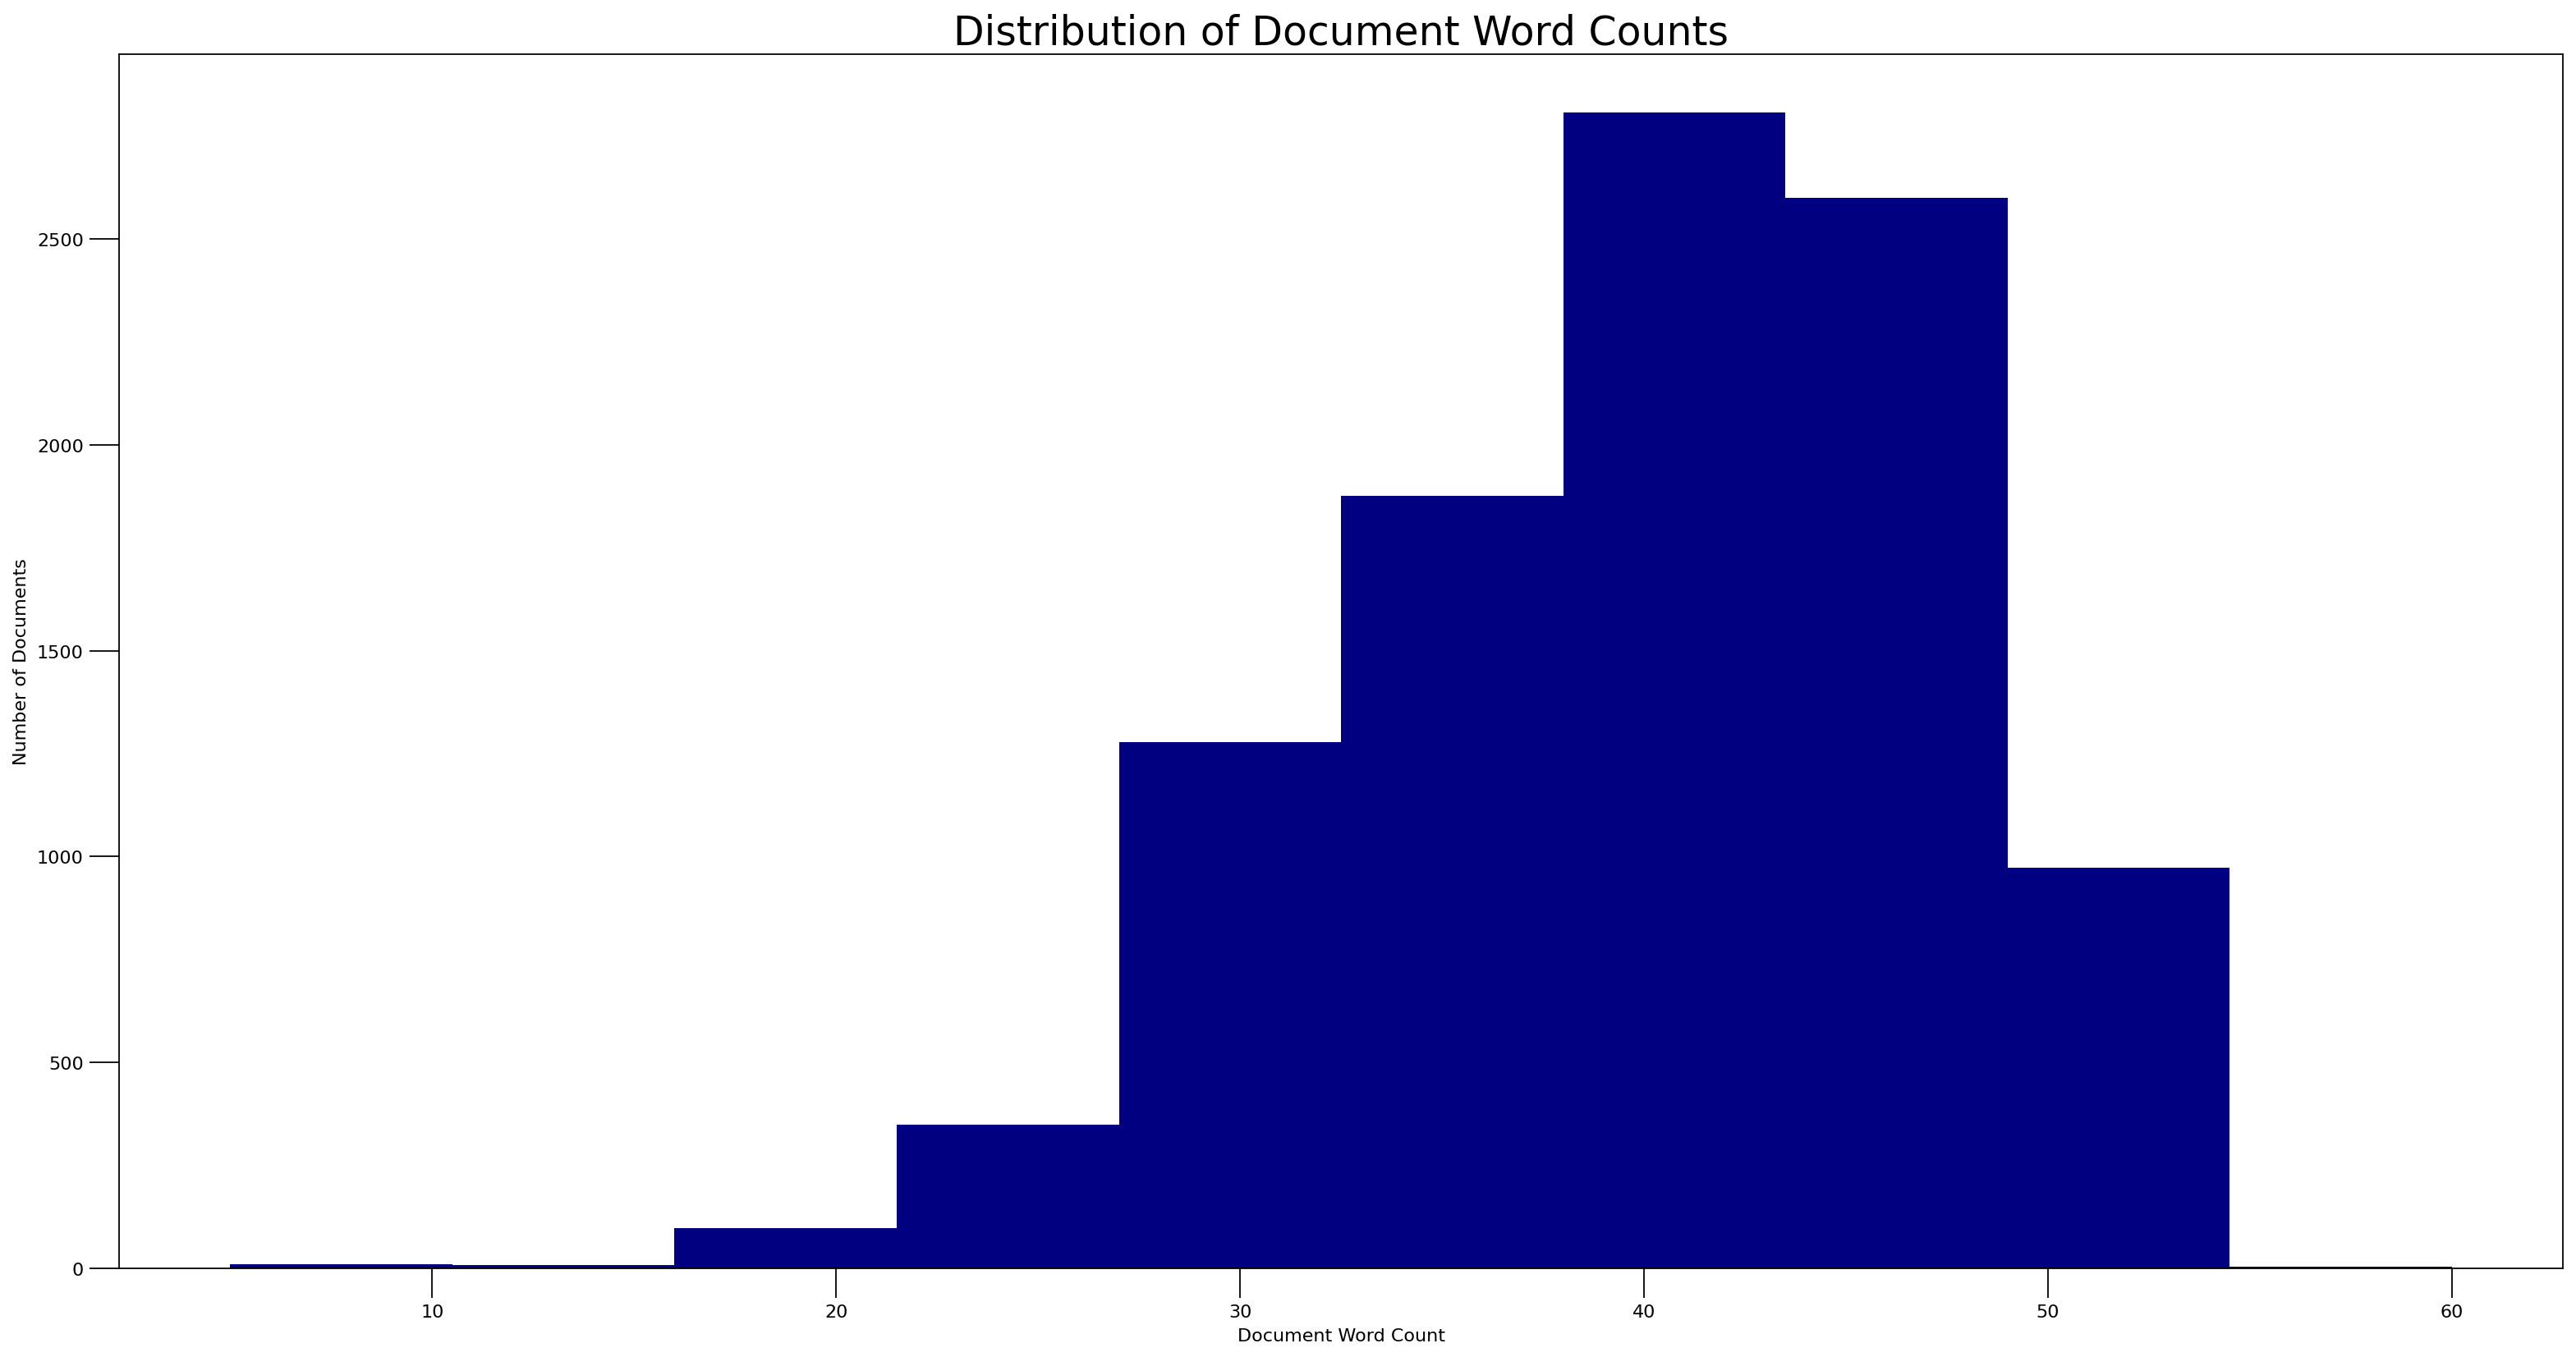

In [155]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(24,12), dpi=160)
plt.hist(doc_lens, color='navy') #, bins = 100)
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count',) # xlim=(0, 100),)
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

#### By Topic

/tmp/ipykernel_19351/3230018202.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipykernel_19351/3230018202.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipykernel_19351/3230018202.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
/tmp/ipykernel_19351/3230018202.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d

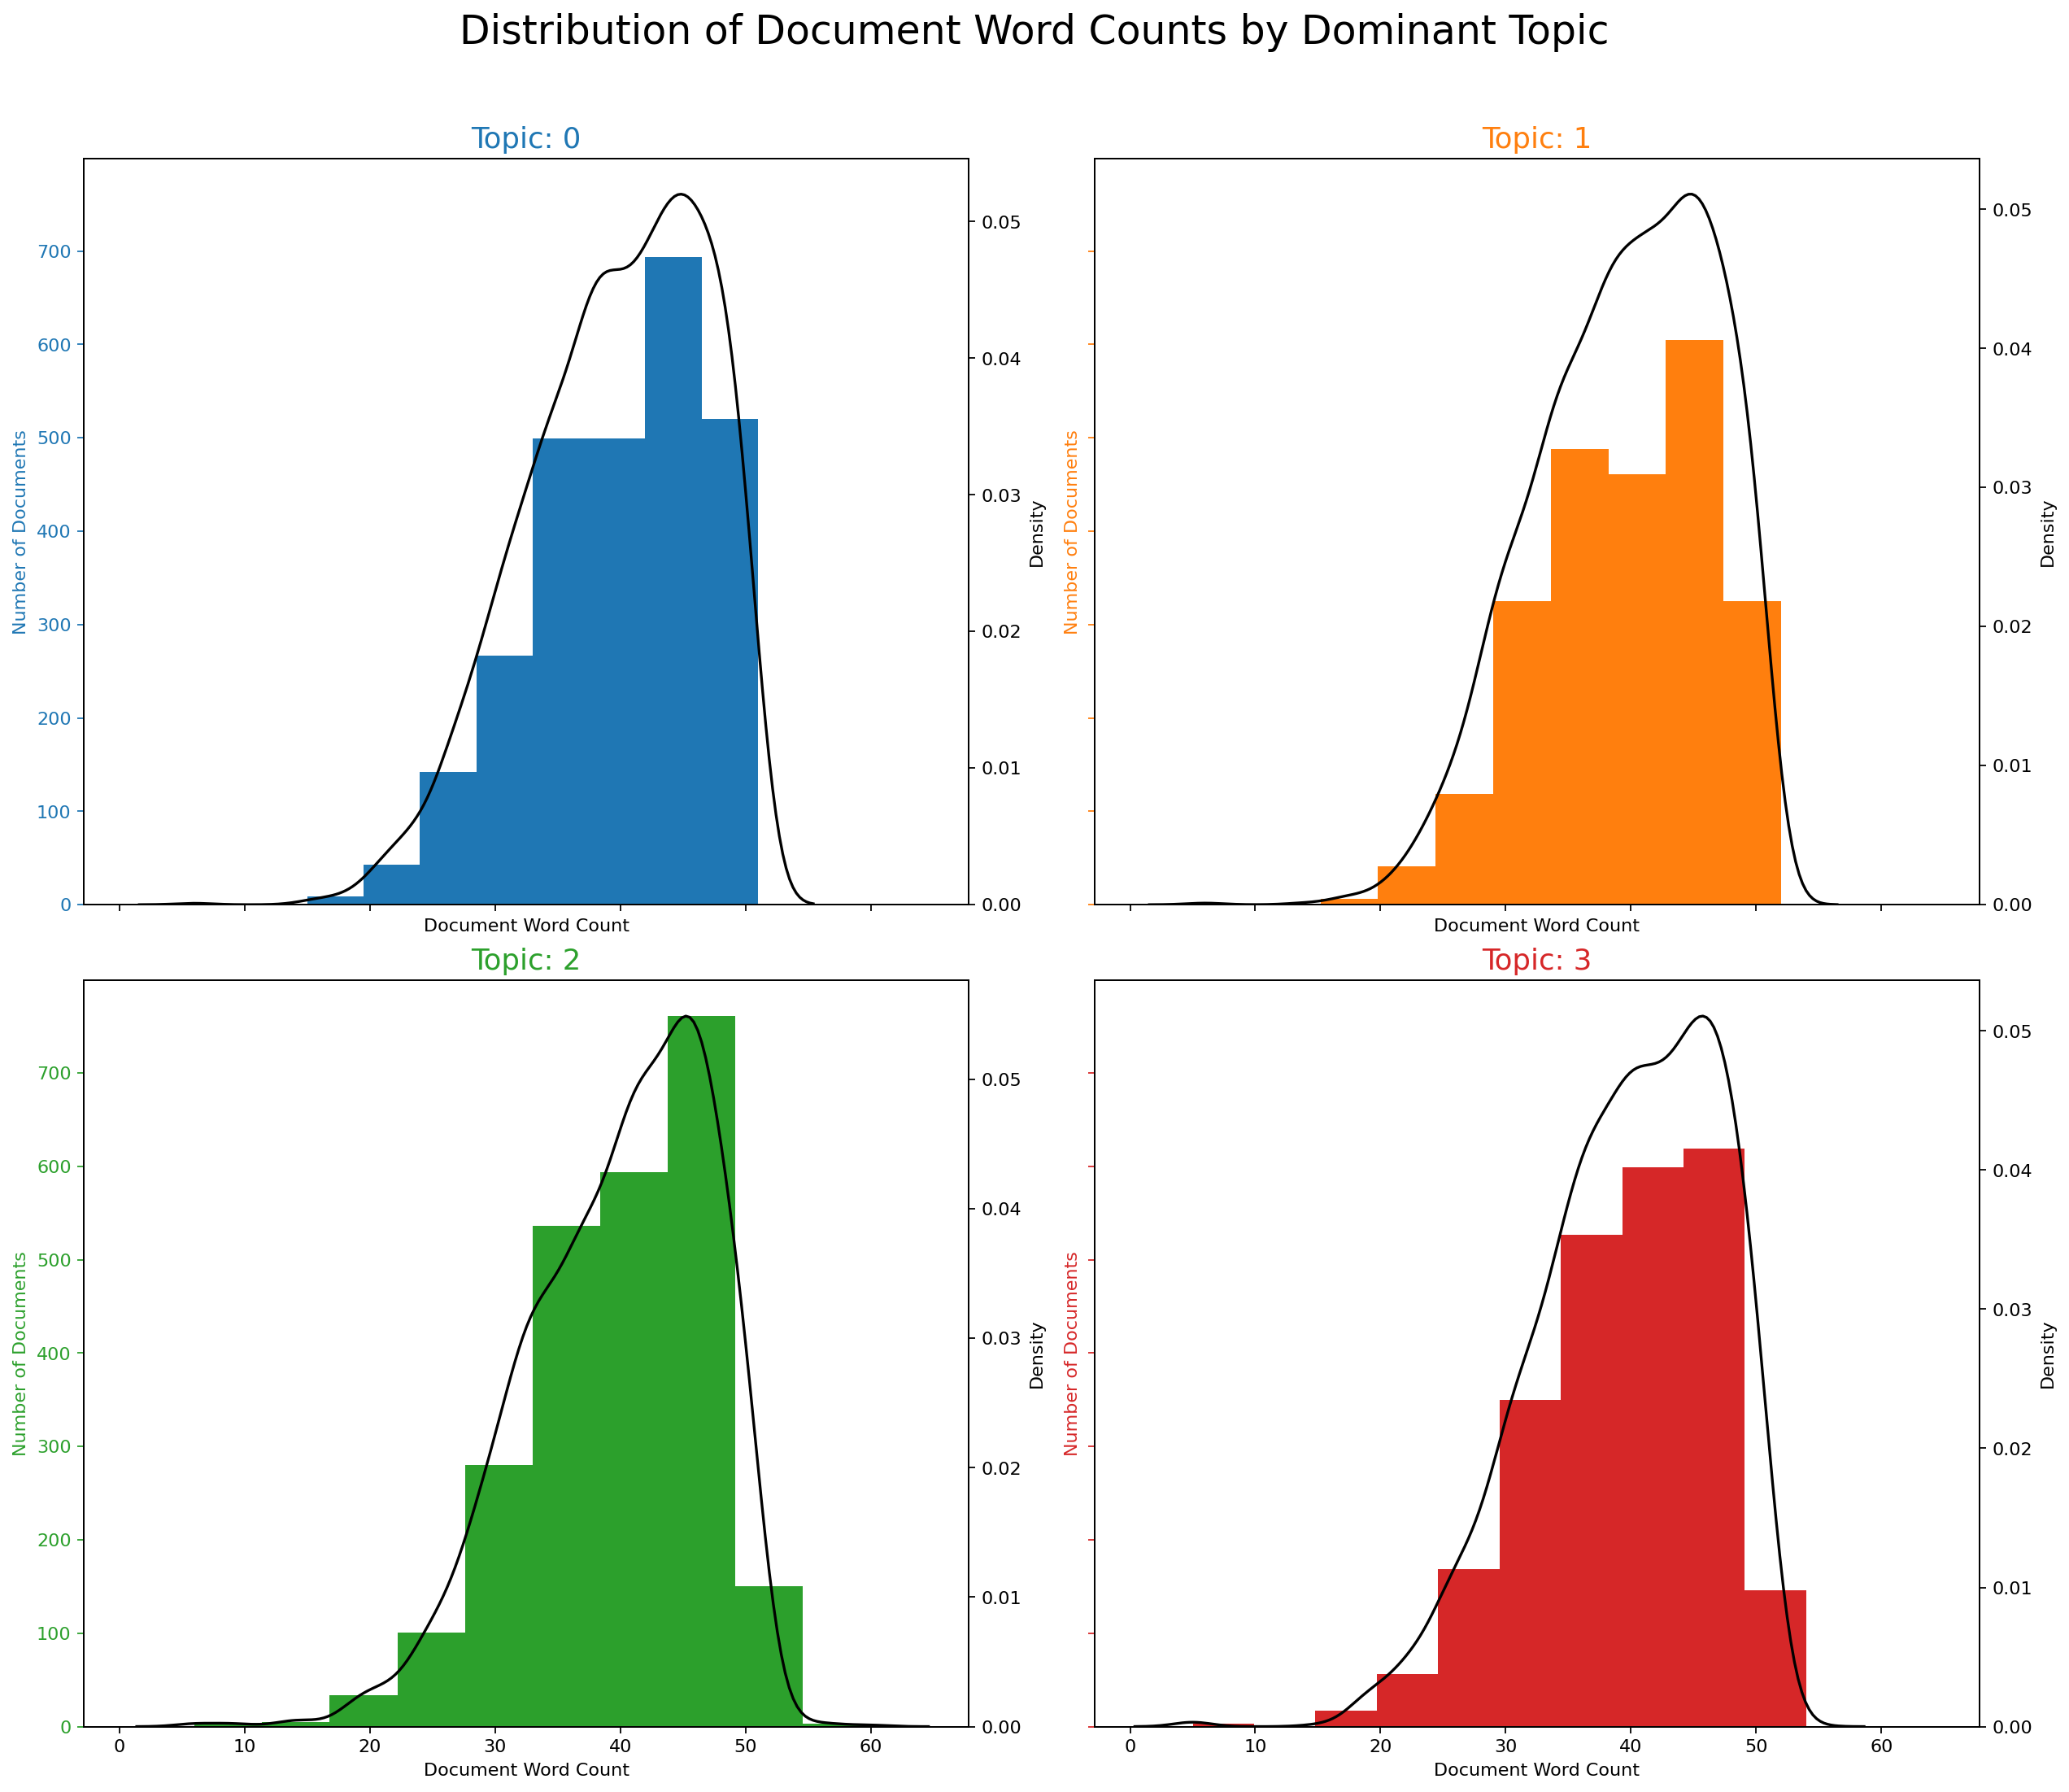

In [156]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

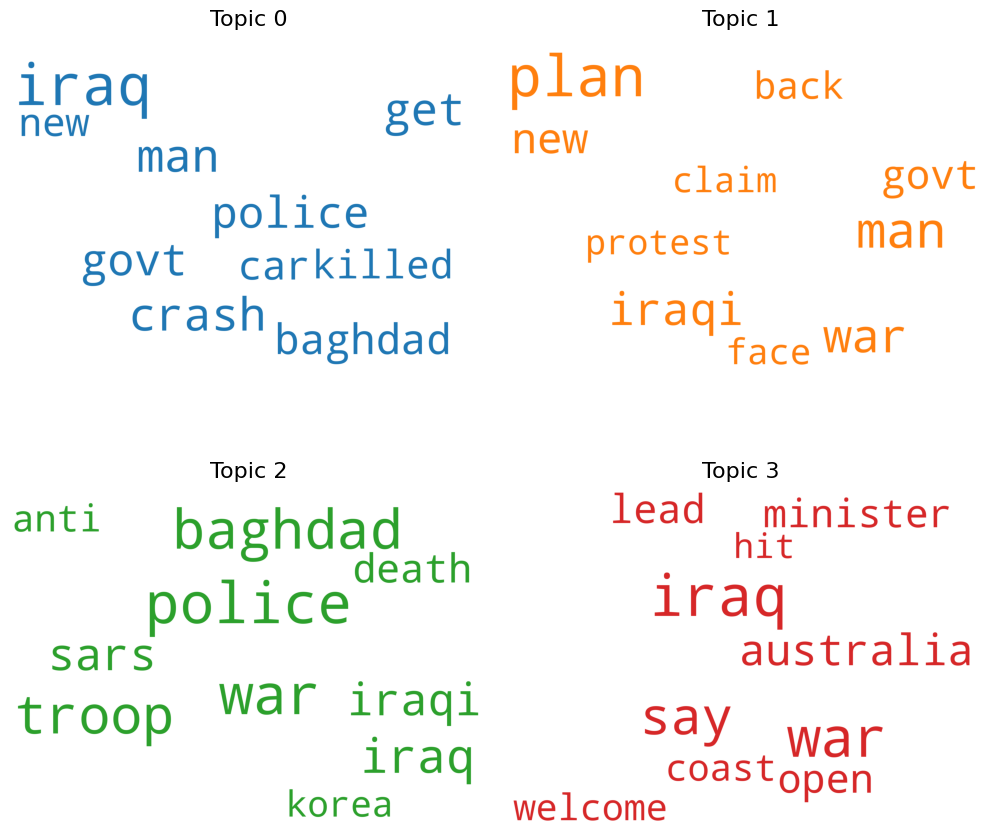

In [157]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Counts of Topic Keywords

/tmp/ipykernel_19351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_19351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_19351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_19351/4070907284.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


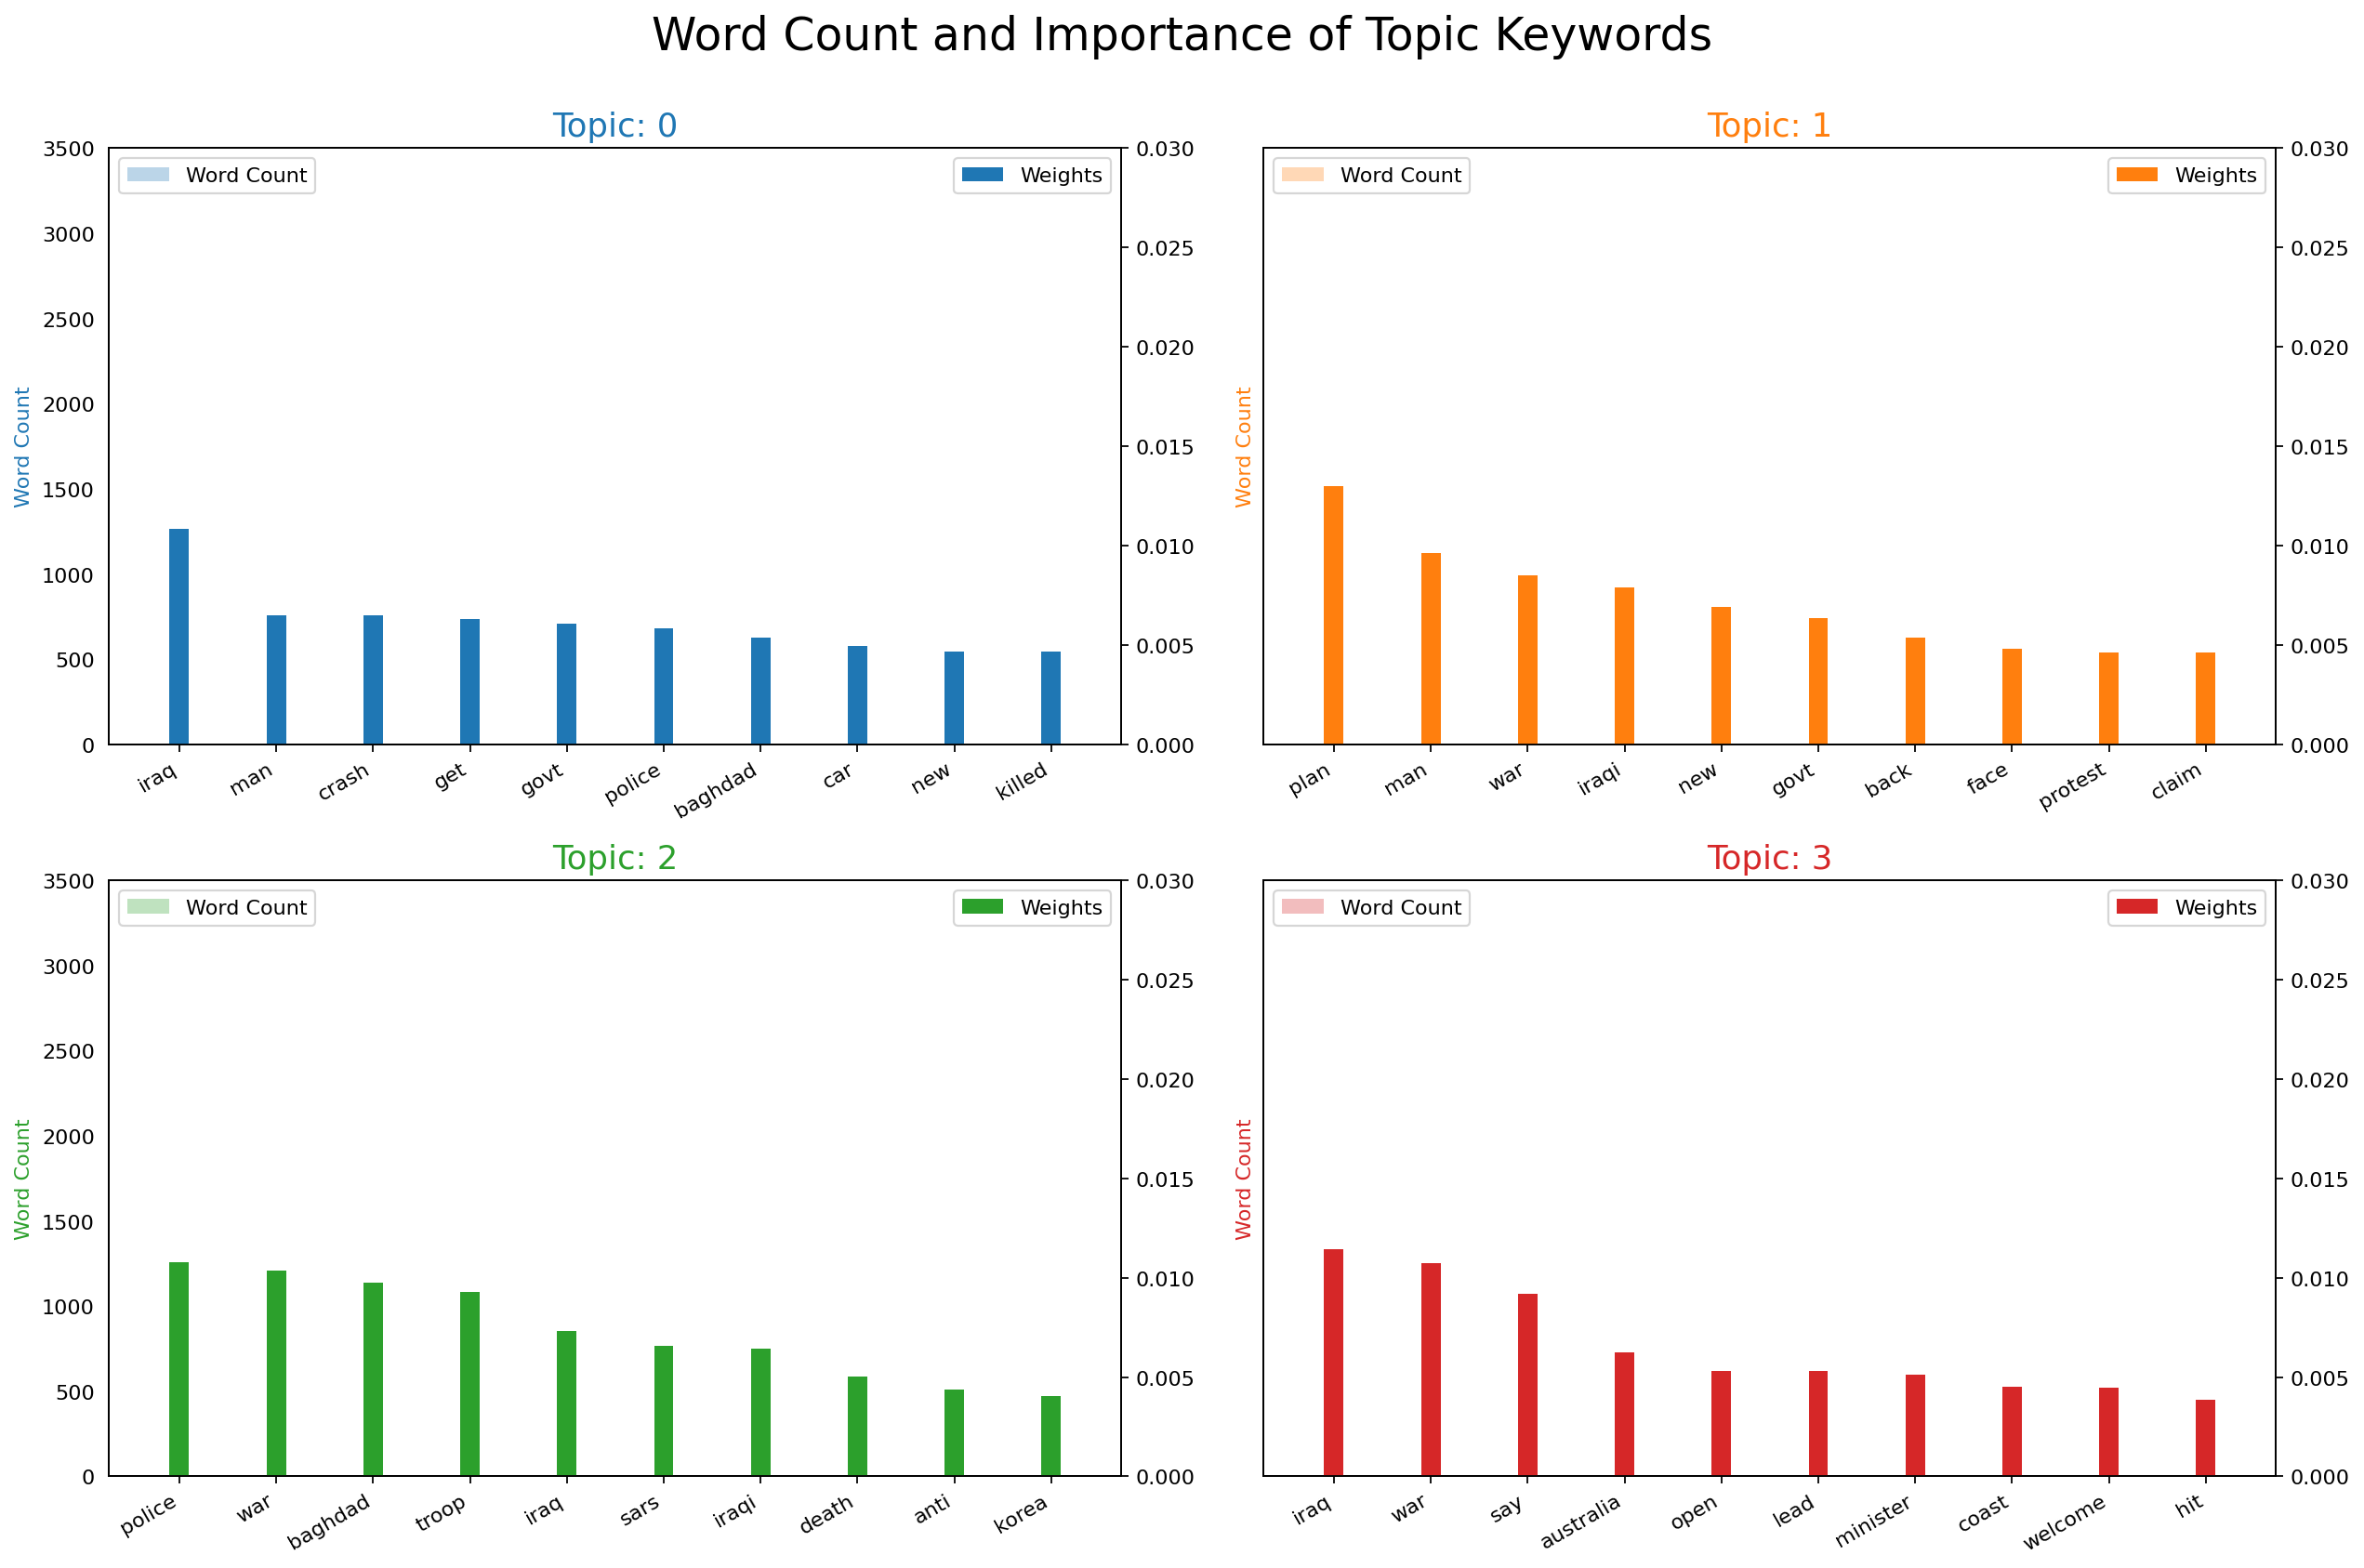

In [158]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in news['headline_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Sentence Chart Colored by Topic

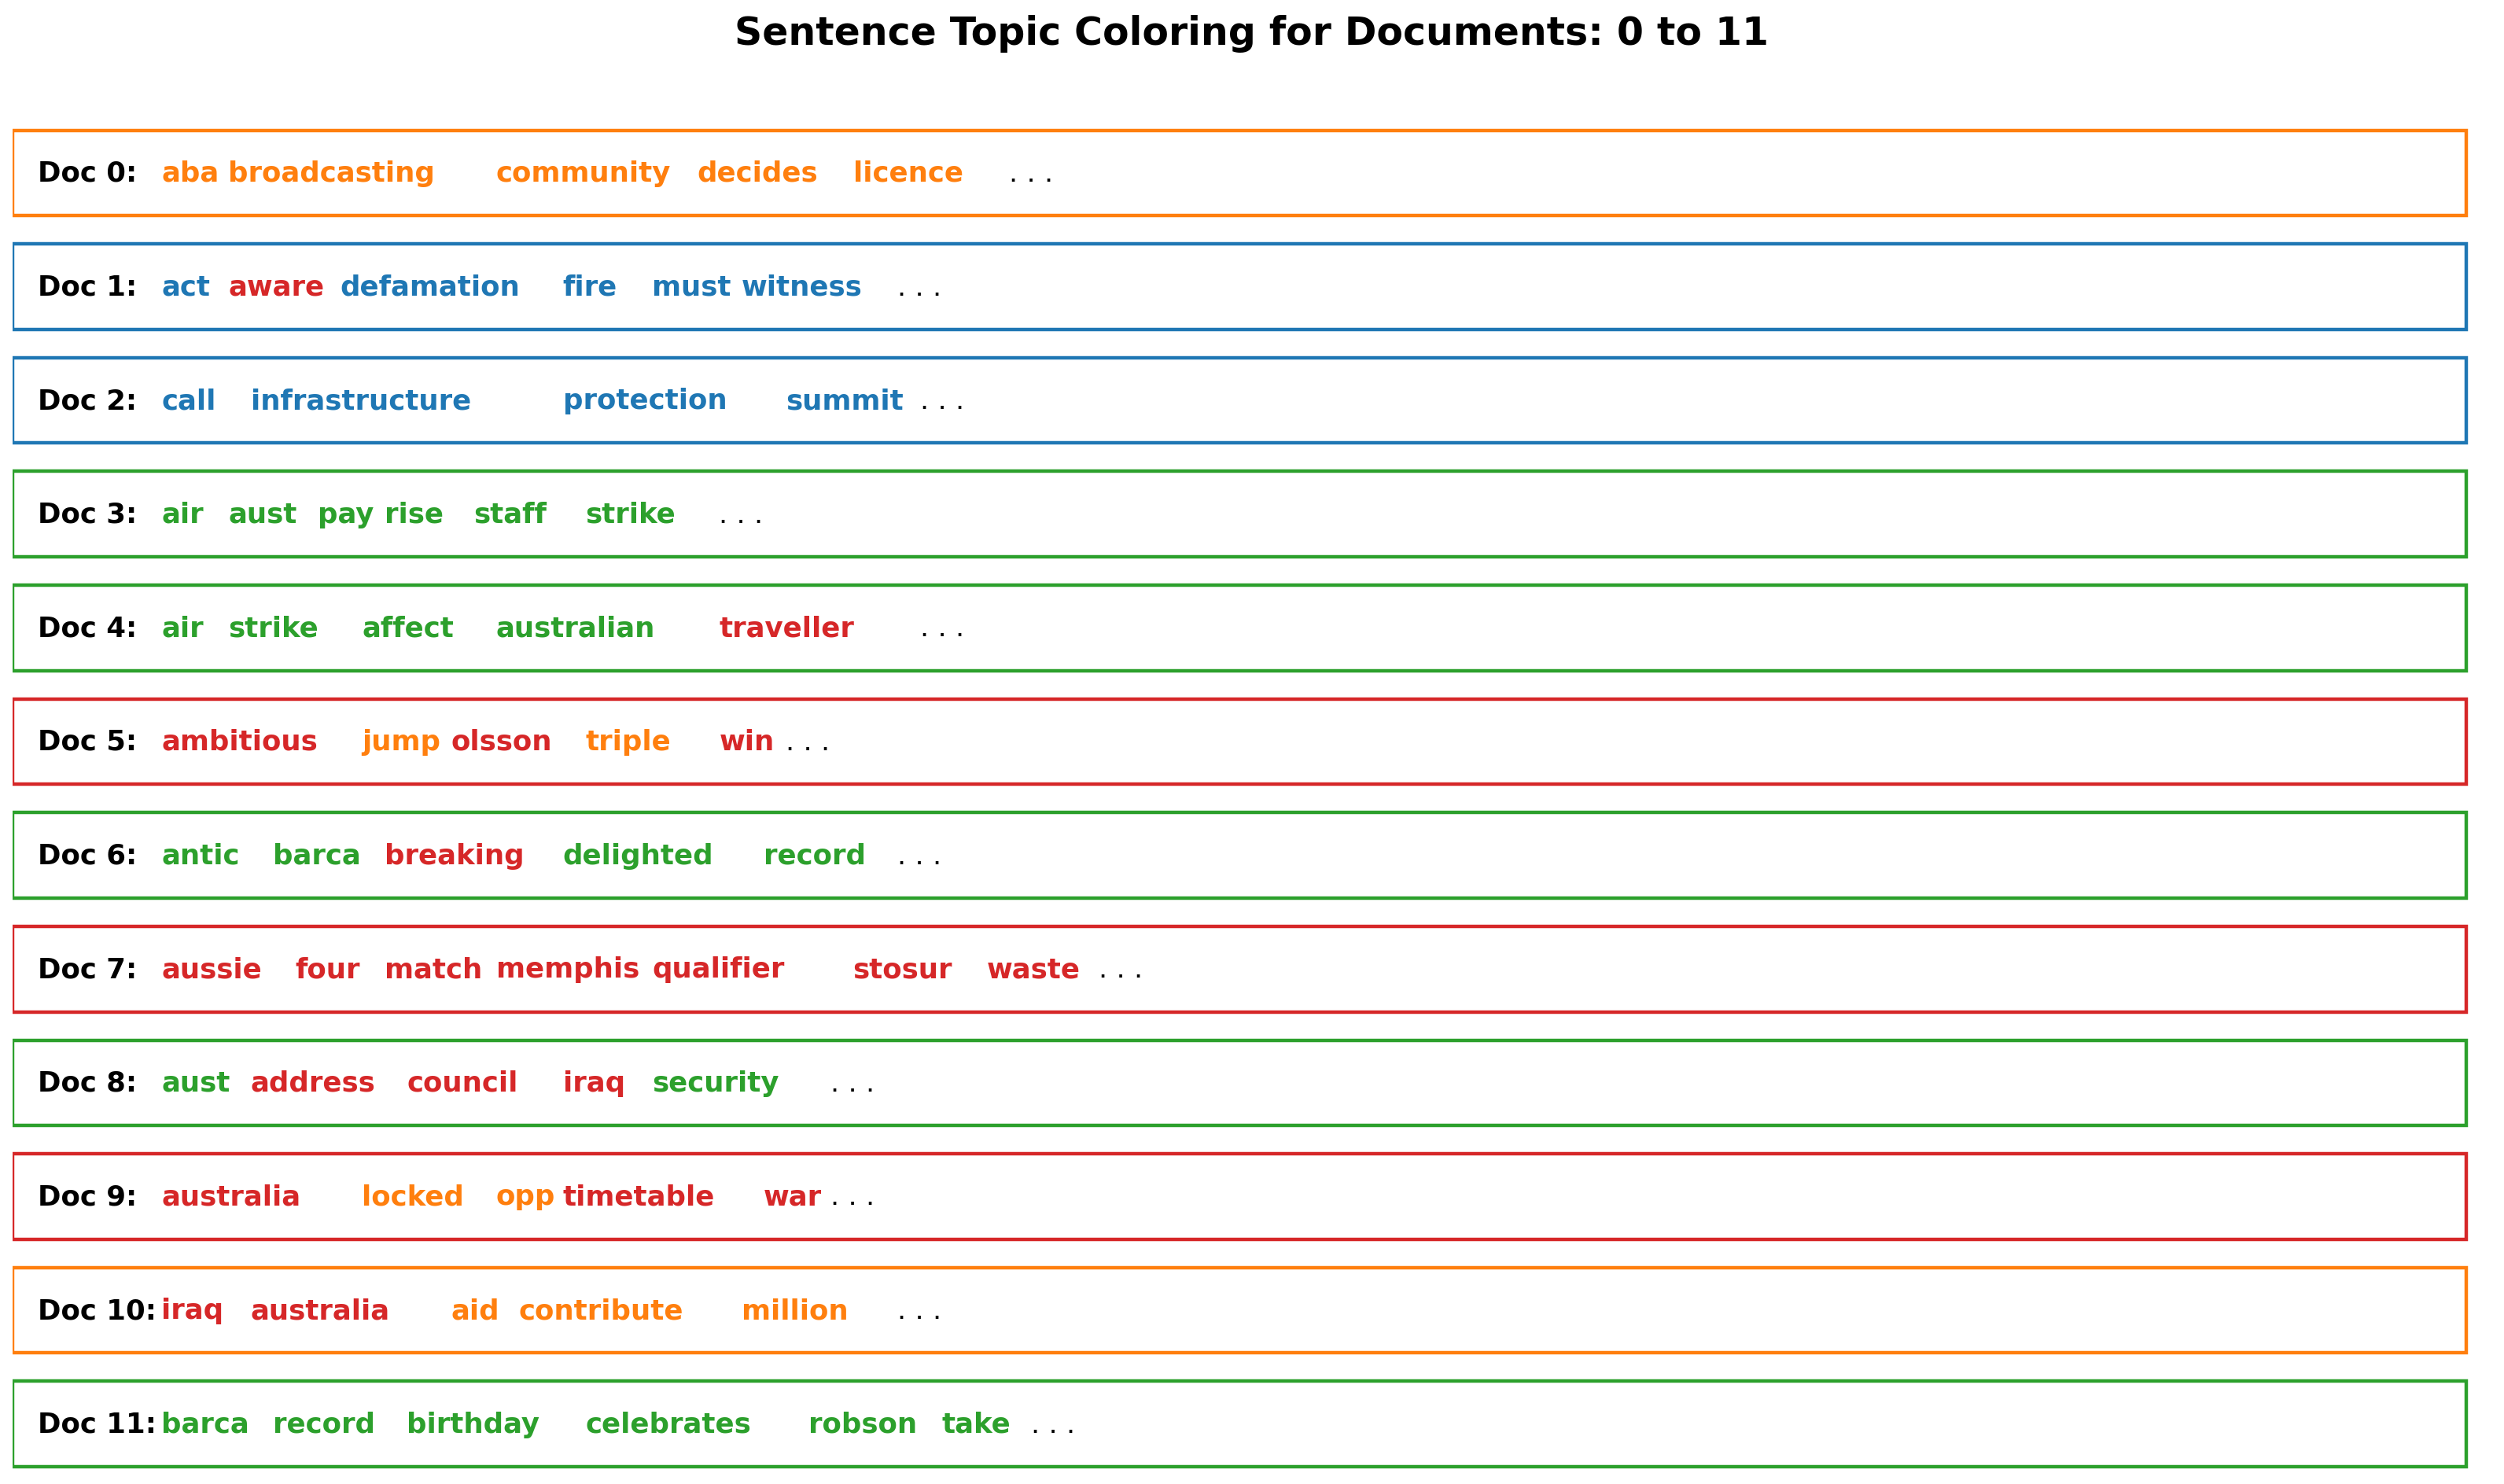

In [159]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 
                    0.5, 
                    "Doc " + str(i-1) + ": ", 
                    verticalalignment='center',
                    fontsize=16, 
                    color='black',
                    transform=ax.transAxes, 
                    fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, 
                    '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model, bow_corpus)    

#### What are the most discussed topics in the documents?

In [160]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

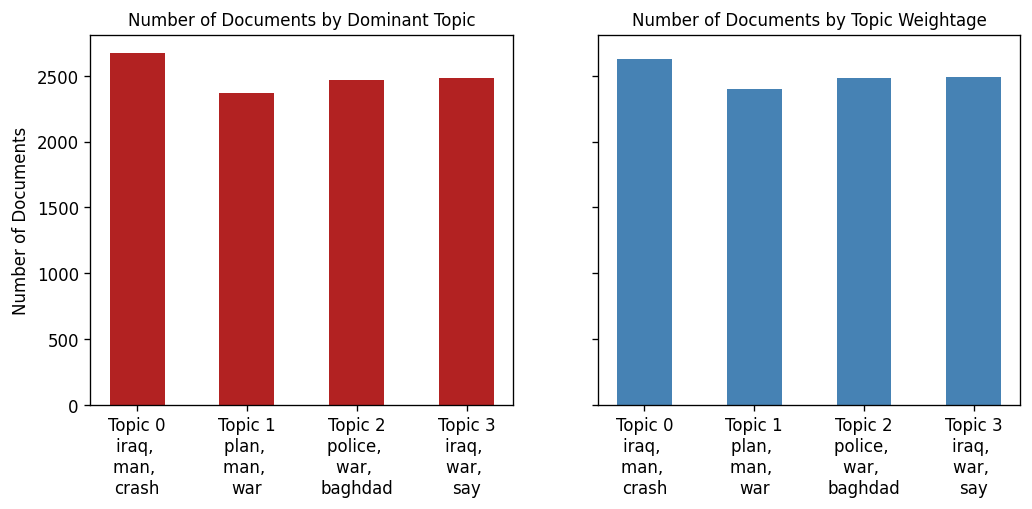

In [161]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### t-SNE Clustering Chart

In [167]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/home/renato/Documents/env_default/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9979 samples in 0.004s...
[t-SNE] Computed neighbors for 9979 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9979
[t-SNE] Computed conditional probabilities for sample 2000 / 9979
[t-SNE] Computed conditional probabilities for sample 3000 / 9979
[t-SNE] Computed conditional probabilities for sample 4000 / 9979
[t-SNE] Computed conditional probabilities for sample 5000 / 9979
[t-SNE] Computed conditional probabilities for sample 6000 / 9979
[t-SNE] Computed conditional probabilities for sample 7000 / 9979
[t-SNE] Computed conditional probabilities for sample 8000 / 9979
[t-SNE] Computed conditional probabilities for sample 9000 / 9979
[t-SNE] Computed conditional probabilities for sample 9979 / 9979
[t-SNE] Mean sigma: 0.001007


/home/renato/Documents/env_default/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.015228
[t-SNE] KL divergence after 1000 iterations: 0.751418


Loading BokehJS ...

#### Visualizes the results of LDA interactively

In [171]:
import pyLDAvis
import pyLDAvis.gensim_models

In [172]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

/home/renato/Documents/env_default/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/renato/Documents/env_default/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/renato/Documents/env_default/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/renato/Documents/env_default/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importli

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.110220 -0.011248       1        1  26.215692
3     -0.119819 -0.127244       2        1  25.005520
2      0.092516 -0.014382       3        1  24.822345
1     -0.082918  0.152874       4        1  23.956442, topic_info=         Term        Freq       Total Category  logprob  loglift
60       plan  160.000000  160.000000  Default  30.0000  30.0000
79      troop  122.000000  122.000000  Default  29.0000  29.0000
3495  baghdad  196.000000  196.000000  Default  28.0000  28.0000
317       man  208.000000  208.000000  Default  27.0000  27.0000
275    police  244.000000  244.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
199       nsw   37.438072  110.179876   Topic4  -5.7880   0.3495
42    council   40.563338  167.313033   Topic4  -5.7078   0.0119
280     group   31.439186   75.220199   Topic4  -5.9626   0.5566
43       iraq   43.693689  427.155182   Topic4  -5.6335  -0.8510
488     world   32.748354  110.106769   Topic4  -5.9218   0.2163

[292 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
715       4  0.924769  accuses
5         1  0.162623      act
5         2  0.130098      act
5         3  0.146360      act
5         4  0.536655      act
...     ...       ...      ...
488       3  0.299709    world
488       4  0.299709    world
1352      1  0.986704     year
1352      2  0.015662     year
2426      4  0.973561      yet

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

#### Wordcloud

/home/renato/Documents/env_default/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/renato/Documents/env_default/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/renato/Documents/env_default/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/renato/Documents/env_default/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01).

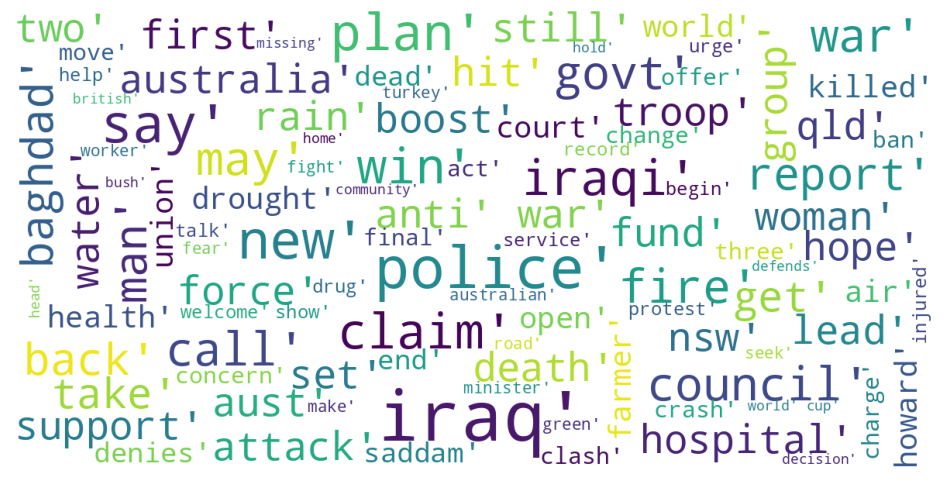

In [173]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

#### Sentiment analysis

In [ ]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score'] = news['headline_text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

#### Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

In [ ]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))
plt.bar(news.polarity.value_counts().index, news.polarity.value_counts())

In [ ]:
news[news['polarity'] == 'pos']['headline_text'].head()

In [ ]:
news[news['polarity'] == 'neg']['headline_text'].head()

#### Vader Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index, polarity.value_counts())

#### Named Entity Recognition

In [ ]:
#!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

In [ ]:
from spacy import displacy

displacy.render(doc, style='ent')

In [ ]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

#### Now, we can visualize the entity frequencies: 

In [ ]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

#### We can also visualize the most common token per entity

In [ ]:
def ner(text, ent="GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = news['headline_text'].apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x)

#### Most common names on News headlines

In [ ]:
per = news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(x=y,y=x)

#### Exploration through Parts of Speach Tagging in python

In [ ]:
import nltk
sentence = "The greatest comeback stories in 2019"
tokens = nltk.tokenize.word_tokenize(sentence)
nltk.pos_tag(tokens)

In [ ]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#### Now that we now what POS tagging is, let’s use it to explore our headlines dataset

In [ ]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = news['headline_text'].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### We can dig deeper into this by investigating which singular noun occur most commonly in news headlines

In [ ]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = news['headline_text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### Exploring through text complexity  

Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.  

In [ ]:
from textstat import flesch_reading_ease

news['headline_text'].apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5  

In [ ]:
news['reading'] = news['headline_text'].apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(news['reading'])) if news['reading'].iloc[i] < 5]
news.iloc[x]['headline_text'].head()